In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

from astropy.table import Table,join,hstack,vstack
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import corner

In [2]:
# First read in the unvalidated GALAH DR4 file
galah_dr4_raw = Table.read('../spectrum_post_processing/galah_dr4_allspec_not_validated.fits')

In [3]:
def get_and_join_data(directory = '/Users/svenbuder/GALAH_DR3/catalogs/'):
    
    # Join all data
    galah_dr3_main = Table.read(directory+'GALAH_DR3_main_allspec_v2.fits')
    galah_dr3_dynamics = Table.read(directory+'GALAH_DR3_VAC_dynamics_v2.fits')
    data_12 = join(galah_dr3_main, galah_dr3_dynamics, keys='sobject_id')
    galah_dr3_main = []; galah_dr3_dynamics = [];
    galah_dr3_gaiaedr3 = Table.read(directory+'GALAH_DR3_VAC_GaiaEDR3_v2.fits')
    data_123 = join(data_12, galah_dr3_gaiaedr3, keys='sobject_id')
    data_12 = []; galah_dr3_gaiaedr3 = []
    galah_dr3_ages = Table.read(directory+'GALAH_DR3_VAC_ages_v2.fits')
    data_1234 = join(data_123, galah_dr3_ages, keys='sobject_id')
    data_123 = []; galah_dr3_ages = []
    galah_dr3_rv = Table.read(directory+'GALAH_DR3_VAC_rv_v2.fits')
    data = join(data_1234, galah_dr3_rv, keys='sobject_id')
    data_1234 = []; galah_dr3_rv = []
    
    # get best rv and e_rv
    data['best_rv'] = np.zeros(len(data['sobject_id'])); data['best_rv'][:] = np.nan;
    data['best_rv'][data['use_rv_flag_1']==0] = data['rv_obst'][data['use_rv_flag_1']==0]
    data['best_rv'][data['use_rv_flag_1']==1] = data['rv_sme_v2'][data['use_rv_flag_1']==1]
    data['best_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_1'][data['use_rv_flag_1']==2]

    data['best_e_rv'] = np.zeros(len(data['sobject_id'])); data['best_e_rv'][:] = np.nan;
    data['best_e_rv'][data['use_rv_flag_1']==0] = data['e_rv_obst'][data['use_rv_flag_1']==0]
    data['best_e_rv'][data['use_rv_flag_1']==1] = data['e_rv_sme'][data['use_rv_flag_1']==1]
    data['best_e_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_error_1'][data['use_rv_flag_1']==2]
    
    # get best distance and 16th + 84th percentile
    data['best_d'] = np.zeros(len(data['sobject_id'])); data['best_d'][:] = np.nan;
    data['best_d_16'] = np.zeros(len(data['sobject_id'])); data['best_d_16'][:] = np.nan;
    data['best_d_50'] = np.zeros(len(data['sobject_id'])); data['best_d_50'][:] = np.nan;
    data['best_d_84'] = np.zeros(len(data['sobject_id'])); data['best_d_84'][:] = np.nan;

    data['best_d'][data['use_dist_flag']==0] = 1000.*data['distance_bstep'][data['use_dist_flag']==0]
    data['best_d_16'][data['use_dist_flag']==0] = 1000.*data['e16_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_50'][data['use_dist_flag']==0] = 1000.*data['e50_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_84'][data['use_dist_flag']==0] = 1000.*data['e84_distance_bstep'][data['use_dist_flag']==0]

    data['best_d'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_16'][data['use_dist_flag']==1] = data['r_lo_photogeo'][data['use_dist_flag']==1]
    data['best_d_50'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_84'][data['use_dist_flag']==1] = data['r_hi_photogeo'][data['use_dist_flag']==1]

    data['best_d'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_16'][data['use_dist_flag']==2] = data['r_lo_geo'][data['use_dist_flag']==2]
    data['best_d_50'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_84'][data['use_dist_flag']==2] = data['r_hi_geo'][data['use_dist_flag']==2]

    data['best_d'][data['use_dist_flag']==4] = 1000./data['parallax_corr'][data['use_dist_flag']==4]
    data['best_d_16'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]+data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_50'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]-data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_84'][data['use_dist_flag']==4] = 1000./data['r_hi_geo'][data['use_dist_flag']==4]

    data['theta_spherical'] = np.arctan2(data['R_Rzphi'], data['z_Rzphi'])
    data['rho_spherical'] = np.sqrt((data['R_Rzphi'])**2+(data['z_Rzphi'])**2)
    data['vrho_spherical'] = (data['R_Rzphi']*data['vR_Rzphi'] + data['z_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']
    data['vtheta_spherical'] = (data['z_Rzphi']*data['vR_Rzphi'] - data['R_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']

    return data

# test if joined data file already exists
# try:
#     data = Table.read('/Users/svenbuder/GALAH_DR3/catalogs/GALAH_DR3_all_joined_v2.fits')
# except:
#     data = get_and_join_data()
#     data.write('/Users/svenbuder/GALAH_DR3/catalogs/GALAH_DR3_all_joined_v2.fits')

# Then read in GALAH DR3
galah_dr3 = Table.read('/Users/svenbuder/GALAH_DR3/catalogs/GALAH_DR3_main_allspec_v2.fits')

In [4]:
# Join them with the tmass_id keyword
joined = join(galah_dr4_raw, galah_dr3, keys='sobject_id',uniq_col_name='{col_name}{table_name}',table_names=['', '_dr3'])

In [5]:
common_keys = dict()
common_keys['teff'] = 'teff_dr3'
common_keys['logg'] = 'logg_dr3'
common_keys['fe_h'] = 'fe_h_dr3'
common_keys['vmic'] = 'vmic_dr3'
common_keys['vsini'] = 'vbroad'
common_keys['li_fe'] = 'Li_fe'
common_keys['c_fe'] = 'C_fe'
common_keys['o_fe'] = 'O_fe'
common_keys['na_fe'] = 'Na_fe'
common_keys['mg_fe'] = 'Mg_fe'
common_keys['al_fe'] = 'Al_fe'
common_keys['si_fe'] = 'Si_fe'
common_keys['k_fe'] = 'K_fe'
common_keys['ca_fe'] = 'Ca_fe'
common_keys['sc_fe'] = 'Sc_fe'
common_keys['ti_fe'] = 'Ti_fe'
common_keys['v_fe'] = 'V_fe'
common_keys['cr_fe'] = 'Cr_fe'
common_keys['mn_fe'] = 'Mn_fe'
common_keys['co_fe'] = 'Co_fe'
common_keys['ni_fe'] = 'Ni_fe'
common_keys['cu_fe'] = 'Cu_fe'
common_keys['zn_fe'] = 'Zn_fe'
common_keys['rb_fe'] = 'Rb_fe'
common_keys['sr_fe'] = 'Sr_fe'
common_keys['y_fe'] = 'Y_fe'
common_keys['zr_fe'] = 'Zr_fe'
common_keys['mo_fe'] = 'Mo_fe'
common_keys['ru_fe'] = 'Ru_fe'
common_keys['ba_fe'] = 'Ba_fe'
common_keys['la_fe'] = 'La_fe'
common_keys['ce_fe'] = 'Ce_fe'
common_keys['nd_fe'] = 'Nd_fe'
common_keys['sm_fe'] = 'Sm_fe'
common_keys['eu_fe'] = 'Eu_fe'

In [6]:
def plot_comparison_hrd(joined, name_literature = 'GALAH DR3'):
    f, gs = plt.subplots(1,4,figsize=(15,5))
    
    unflagged = joined['flag_sp'] == 0
    
    # First panel: GALAH DR4
    ax = gs[0]
    ax.set_xlabel('Teff / K (GALAH DR4)')
    ax.set_ylabel('log (g / cm s-2) (GALAH DR4)')
    ax.scatter(
        joined['teff'][unflagged],
        joined['logg'][unflagged],
        c = joined['fe_h'][unflagged],
        s=1,cmap='plasma',vmin=-2,vmax=0.5
    )
    ax.set_xlim(7800,3200)
    ax.set_ylim(5,0)
    
    # Second Panel: Literature HRD
    ax = gs[1]
    ax.set_xlabel('Teff / K ('+name_literature+')')
    ax.set_ylabel('log (g / cm s-2) ('+name_literature+')')
    ax.scatter(
        joined[common_keys['teff']][unflagged],
        joined[common_keys['logg']][unflagged],
        c = joined[common_keys['fe_h']][unflagged],
        s=1,cmap='plasma',vmin=-2,vmax=0.5
    )
    ax.set_xlim(7800,3200)
    ax.set_ylim(5,0)

    # Third Panel: Difference in Teff
    ax = gs[2]
    ax.set_xlabel('Teff / K ('+name_literature+')')
    ax.set_ylabel(r'$\Delta$Teff / K (GALAH DR4 - '+name_literature+')')
    ax.axhline(0,c='r',lw=1,ls='dashed')
    ax.set_ylim(-500,500)
    ax.scatter(
        joined[common_keys['teff']][unflagged],
        joined['teff'][unflagged] - joined[common_keys['teff']][unflagged],
        s=1,c='k'
    )

    # Fourth Panel: Difference in logg
    ax = gs[3]
    ax.set_xlabel('log (g / cm s-2) ('+name_literature+')')
    ax.set_ylabel(r'$\Delta$log (g / cm s-2) (GALAH DR4 - '+name_literature+')')
    ax.axhline(0,c='r',lw=1,ls='dashed')
    ax.set_ylim(-0.5,0.5)
    ax.scatter(
        joined[common_keys['logg']][unflagged],
        joined['logg'][unflagged] - joined[common_keys['logg']][unflagged],
        s=1,c='k'
    )
    plt.tight_layout()

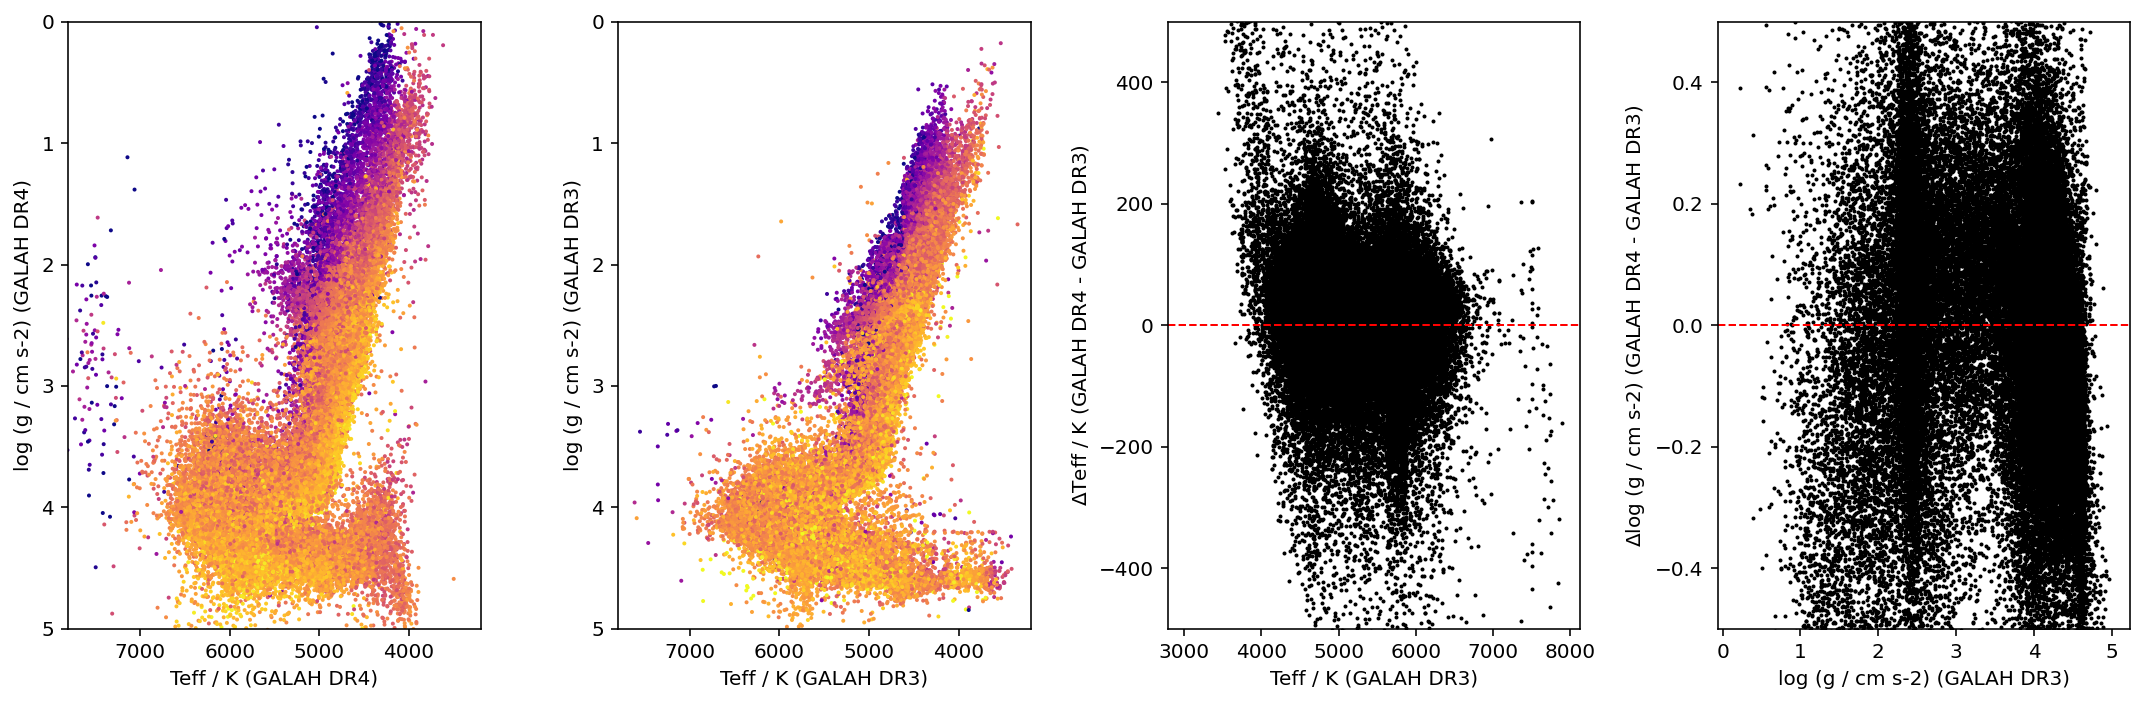

In [7]:
plot_comparison_hrd(joined)

In [8]:
def plot_comparison_stellar_parameters(joined, name_literature = 'GALAH_DR3'):
    f, gs = plt.subplots(1,3,figsize=(15,5))
    
    apply_quality_cuts = (
        np.isfinite(joined['teff']) &
        np.isfinite(joined[common_keys['teff']]) &
        np.isfinite(joined['logg']) &
        np.isfinite(joined[common_keys['logg']]) &
        np.isfinite(joined['fe_h']) &
        np.isfinite(joined[common_keys['fe_h']])
    )
    
    # First panel: Teff
    ax = gs[0]
    ax.set_xlabel(r'Teff / K ('+name_literature+')')
    ax.set_ylabel(r'$\Delta$Teff / K ('+name_literature+' - GALAH_DR4)')
    corner.hist2d(
        joined[common_keys['teff']][apply_quality_cuts],
        joined[common_keys['teff']][apply_quality_cuts]-joined['teff'][apply_quality_cuts],
        ax=ax
    )
    print('Teff',np.percentile(joined[common_keys['teff']][apply_quality_cuts]-joined['teff'][apply_quality_cuts],q=[50]))
    ax.axhline(0,c='r',lw=1,ls='dashed')
    
    # Second panel: logg
    ax = gs[1]
    ax.set_xlabel(r'log (g / cm s-2) ('+name_literature+')')
    ax.set_ylabel(r'$\Delta$log (g / cm s-2) ('+name_literature+' - GALAH_DR4)')
    corner.hist2d(
        joined[common_keys['logg']][apply_quality_cuts],
        joined[common_keys['logg']][apply_quality_cuts]-joined['logg'][apply_quality_cuts],
        ax=ax
    )
    print('logg',np.percentile(joined[common_keys['logg']][apply_quality_cuts]-joined['logg'][apply_quality_cuts],q=[50]))
    ax.axhline(0,c='r',lw=1,ls='dashed')
    
    # First panel: [Fe/H]
    ax = gs[2]
    ax.set_xlabel(r'[Fe/H] ('+name_literature+')')
    ax.set_ylabel(r'$\Delta$[Fe/H] ('+name_literature+' - GALAH_DR4)')
    corner.hist2d(
        joined[common_keys['fe_h']][apply_quality_cuts],
        joined[common_keys['fe_h']][apply_quality_cuts]-joined['fe_h'][apply_quality_cuts],
        ax=ax
    )
    print('[Fe/H]',np.percentile(joined[common_keys['fe_h']][apply_quality_cuts]-joined['fe_h'][apply_quality_cuts],q=[50]))
    ax.axhline(0,c='r',lw=1,ls='dashed')
    
    plt.tight_layout()

Teff [-18.05615234]
logg [0.02701759]
[Fe/H] [-0.00757947]


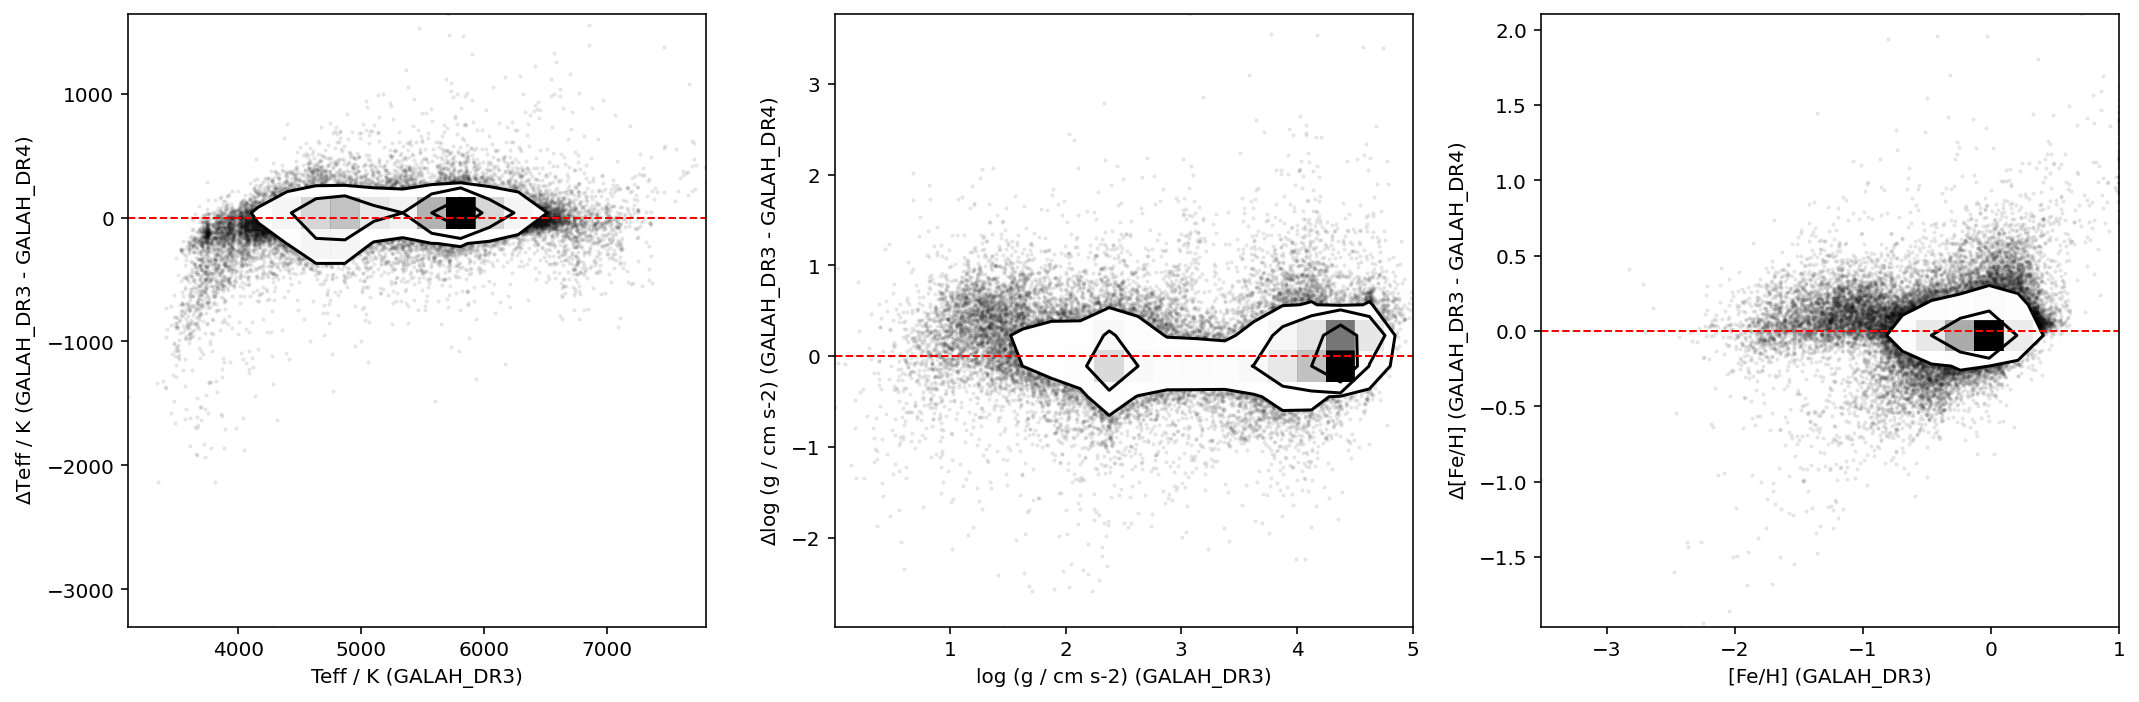

In [9]:
plot_comparison_stellar_parameters(joined)

In [13]:
def plot_comparison_xfe(joined, element = 'C', name_literature = 'GALAH DR3'):
    f, gs = plt.subplots(1,3,figsize=(15,5),sharey=True)
    
    apply_quality_cuts = (
        np.isfinite(joined['fe_h']) &
        np.isfinite(joined[element.lower()+'_fe']) &
        np.isfinite(joined['flag_'+element.lower()+'_fe']==0) &
        np.isfinite(joined[common_keys['fe_h']]) &
        np.isfinite(joined[common_keys[element.lower()+'_fe']]) &
        np.isfinite(joined['flag_'+common_keys[element.lower()+'_fe']] == 0)
    )
    
    xbins = np.linspace(-2.5,0.75,100)
    if element == 'Li':
        ybins = np.linspace(-2,4,100)
    elif element in ['O','Ba','Y']:
        ybins = np.linspace(-2,2,100)
    else:
        ybins = np.linspace(-1,1,100)
    
    # First panel: GALAH DR4 [Fe/H] vs. [X/Fe]
    ax = gs[0]
    ax.set_xlabel('[Fe/H] (GALAH DR4)')
    ax.set_ylabel('['+element+'/Fe] (GALAH DR4)')
    ax.hist2d(
        joined['fe_h'][apply_quality_cuts],
        joined[element.lower()+'_fe'][apply_quality_cuts],
        bins = (xbins,ybins),cmin=1,norm=LogNorm()
    )
    ax.set_xlim(
        np.min([
            np.min(joined['fe_h'][apply_quality_cuts])-0.1,
            np.min(joined[common_keys['fe_h']][apply_quality_cuts])-0.1
        ]),
        np.max([
            np.max(joined['fe_h'][apply_quality_cuts])+0.1,
            np.max(joined[common_keys['fe_h']][apply_quality_cuts])+0.1
        ]),
    )
    
    # Second panel: Literature [Fe/H] vs. [X/Fe]
    ax = gs[1]
    ax.set_xlabel('[Fe/H] ('+name_literature+')')
    ax.set_ylabel('['+element+'/Fe] ('+name_literature+')')
    ax.hist2d(
        joined[common_keys['fe_h']][apply_quality_cuts],
        joined[common_keys[element.lower()+'_fe']][apply_quality_cuts],
        bins = (xbins,ybins),cmin=1,norm=LogNorm()
    )
    ax.set_xlim(
        np.min([
            np.min(joined['fe_h'][apply_quality_cuts])-0.1,
            np.min(joined[common_keys['fe_h']][apply_quality_cuts])-0.1
        ]),
        np.max([
            np.max(joined['fe_h'][apply_quality_cuts])+0.1,
            np.max(joined[common_keys['fe_h']][apply_quality_cuts])+0.1
        ]),
    )
    
    # Third panel: Difference [X/Fe]
    ax = gs[2]
    ax.set_xlabel(r'$\Delta$['+element+'/Fe] ('+name_literature+' - GALAH DR4)')
    ax.set_ylabel('['+element+'/Fe] ('+name_literature+')')
    ax.hist2d(
        joined[common_keys[element.lower()+'_fe']][apply_quality_cuts]-joined[element.lower()+'_fe'][apply_quality_cuts],
        joined[common_keys[element.lower()+'_fe']][apply_quality_cuts],
        bins = (xbins,ybins),cmin=1,norm=LogNorm()
    )
    print(element,np.percentile(joined[common_keys[element.lower()+'_fe']][apply_quality_cuts]-joined[element.lower()+'_fe'][apply_quality_cuts],q=[50]))
    ax.axvline(0,c='r',lw=1,ls='dashed')
    
    plt.tight_layout()
    plt.savefig('figures/galah_dr4_validation_galah_dr3_'+element.lower()+'_fe_density.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

Li [0.54674633]


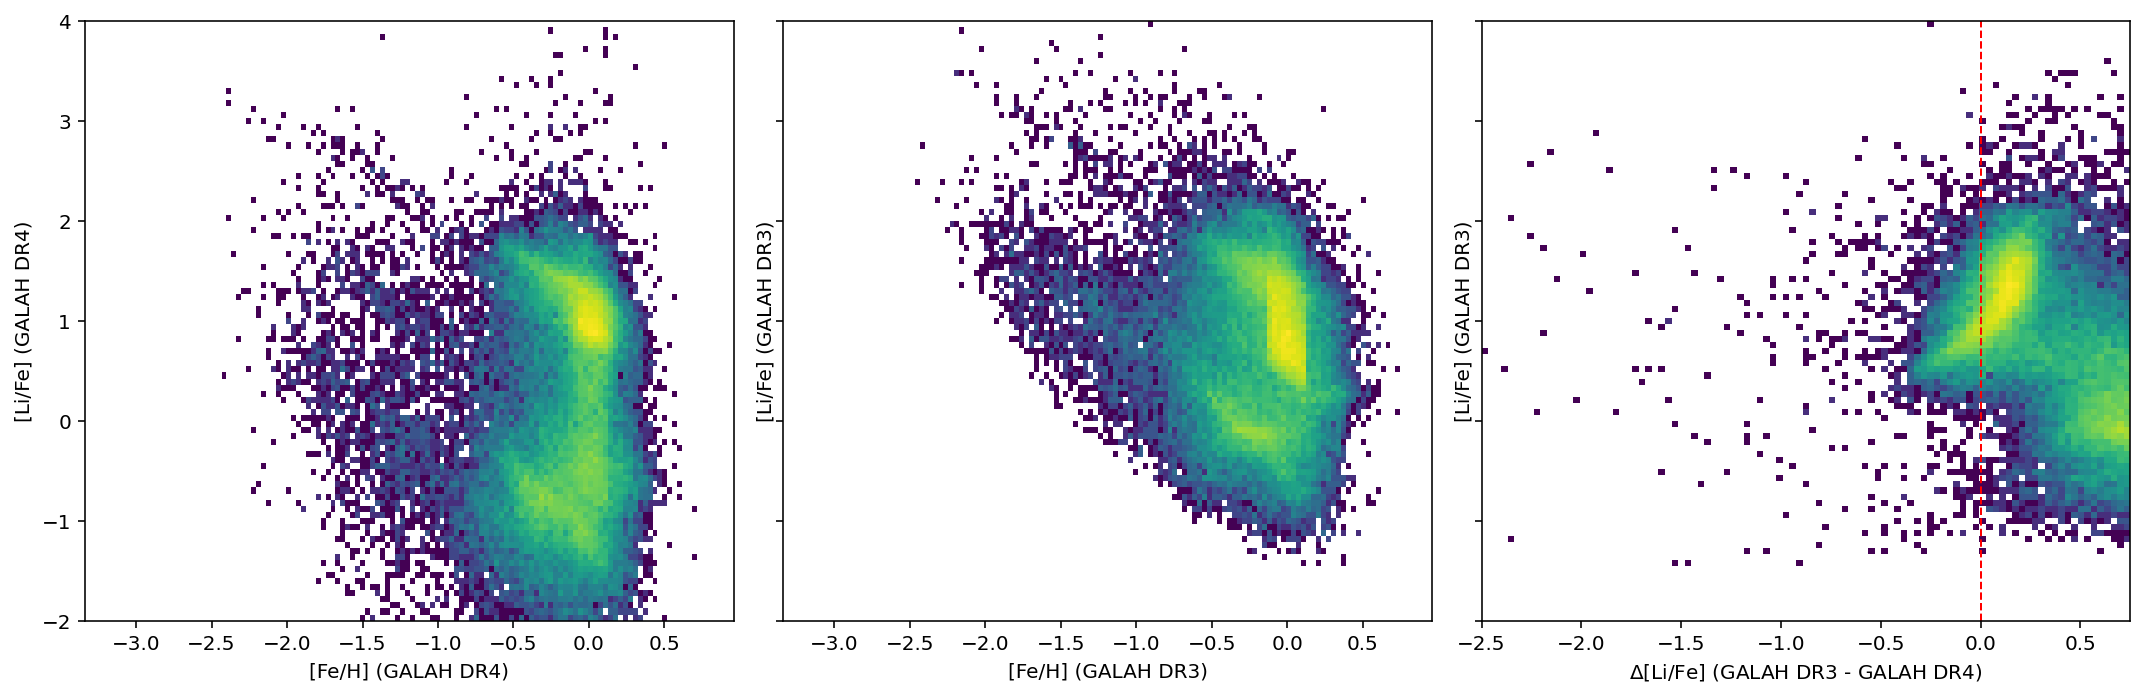

C [0.29731144]


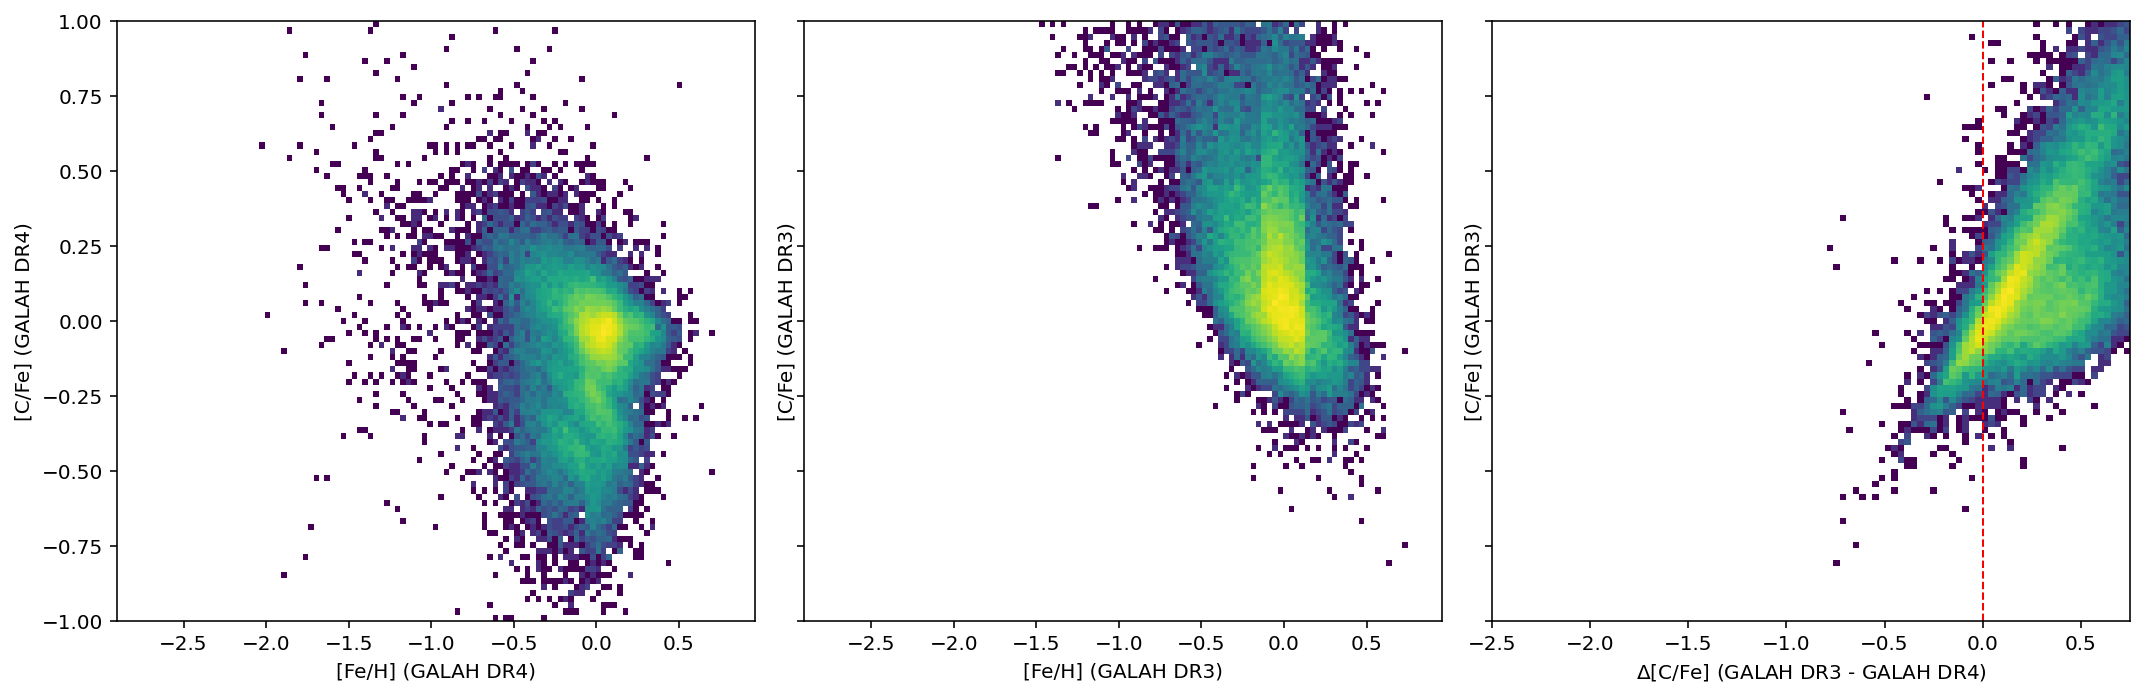

O [0.03087286]


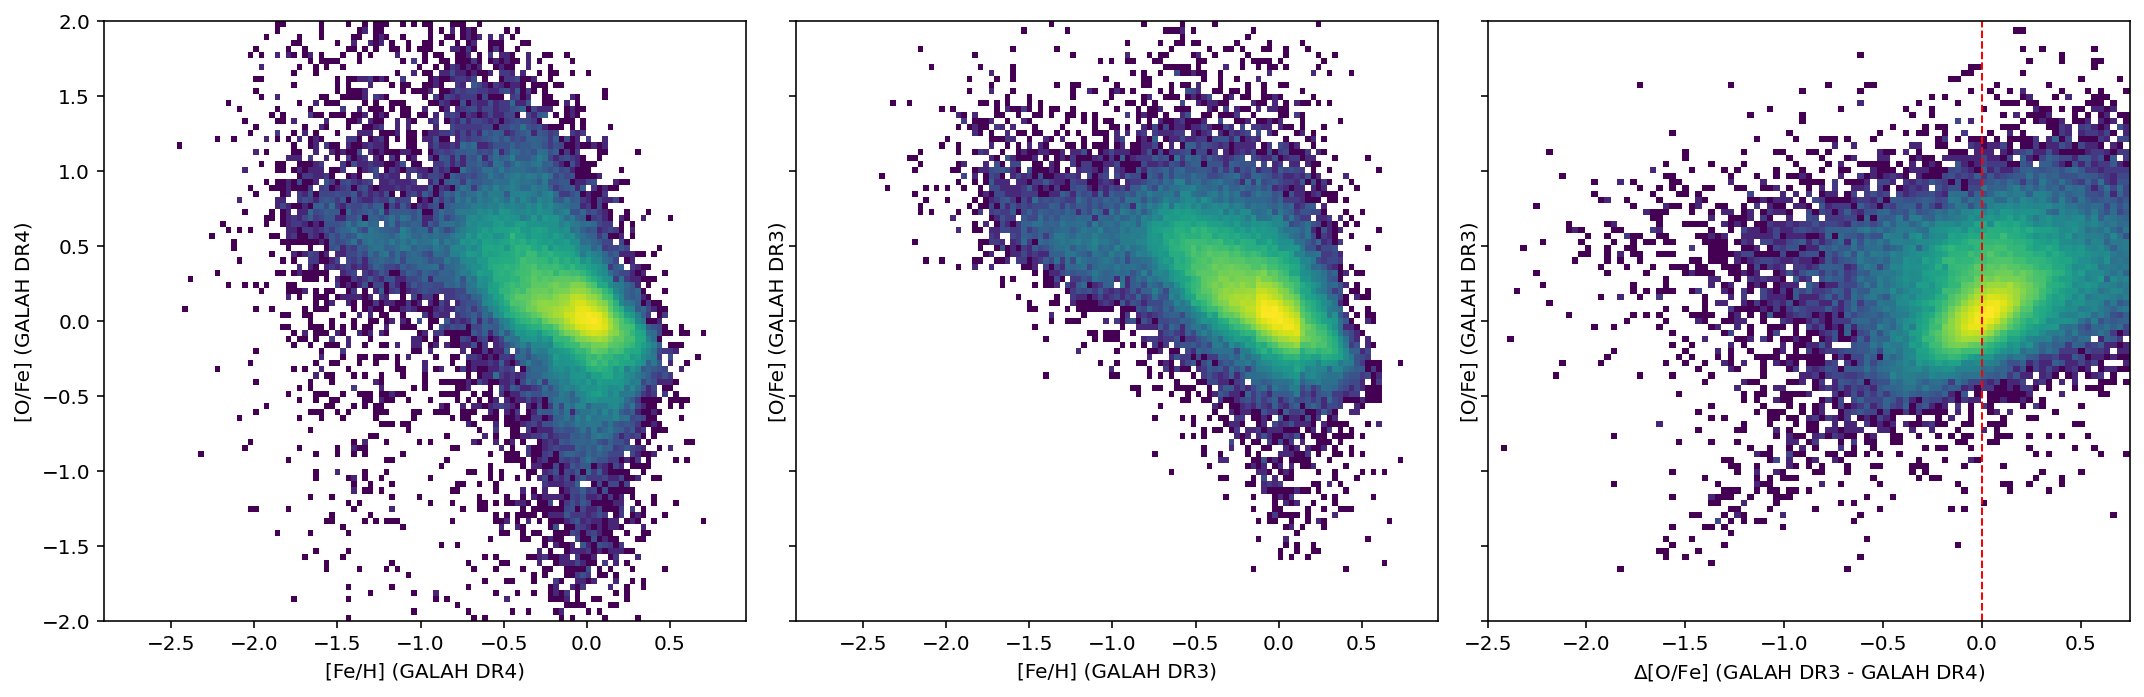

Na [0.0068346]


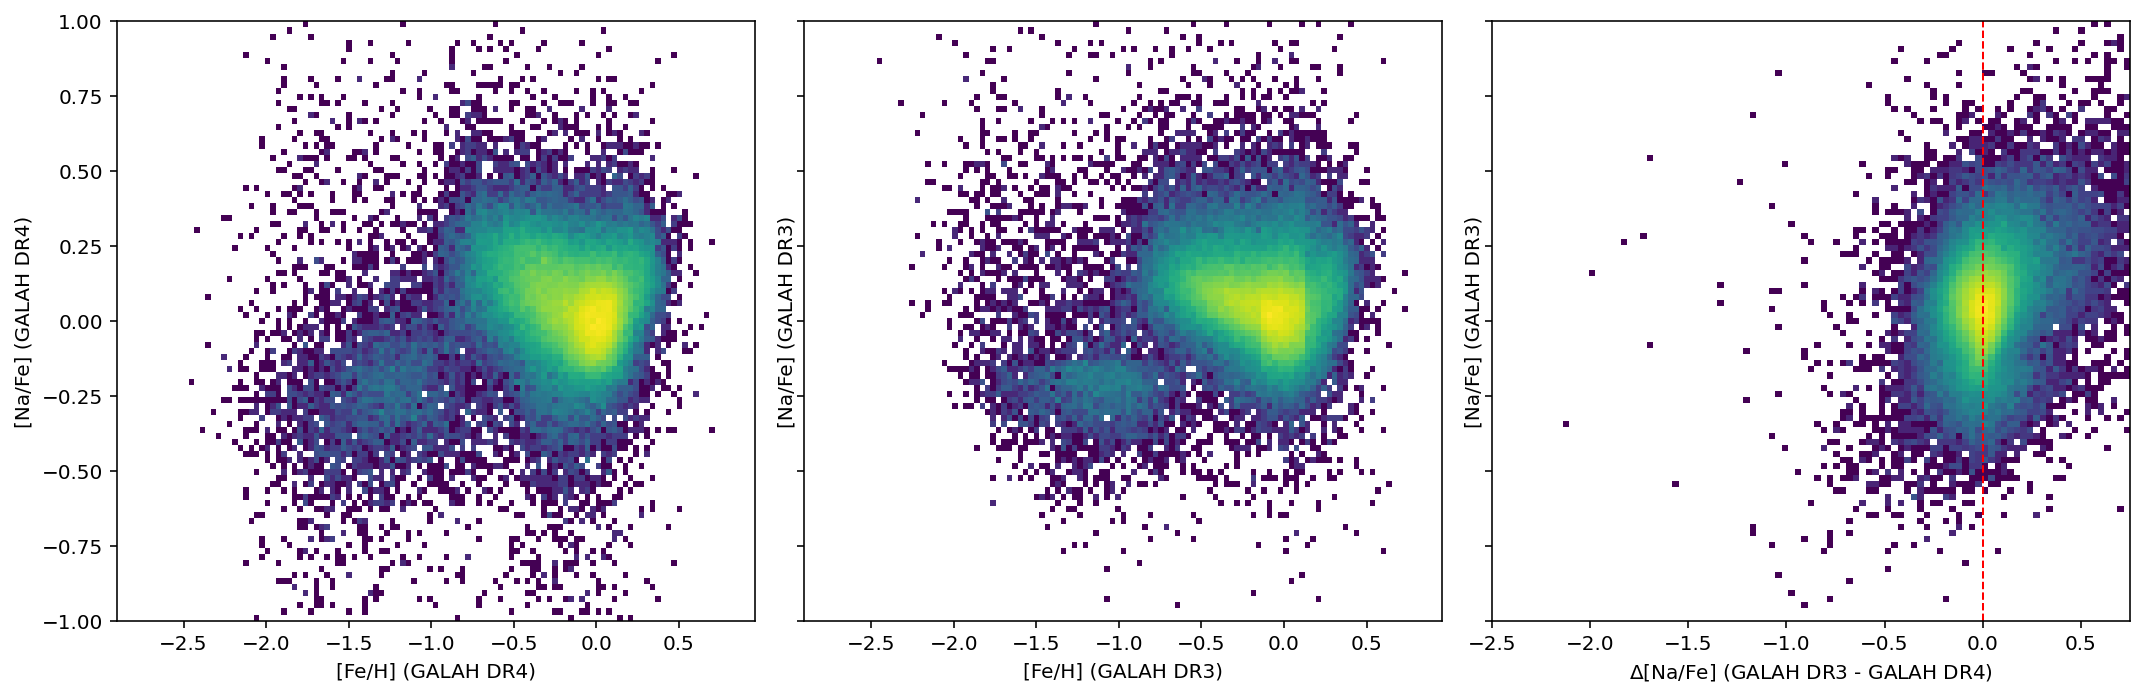

Mg [0.00141106]


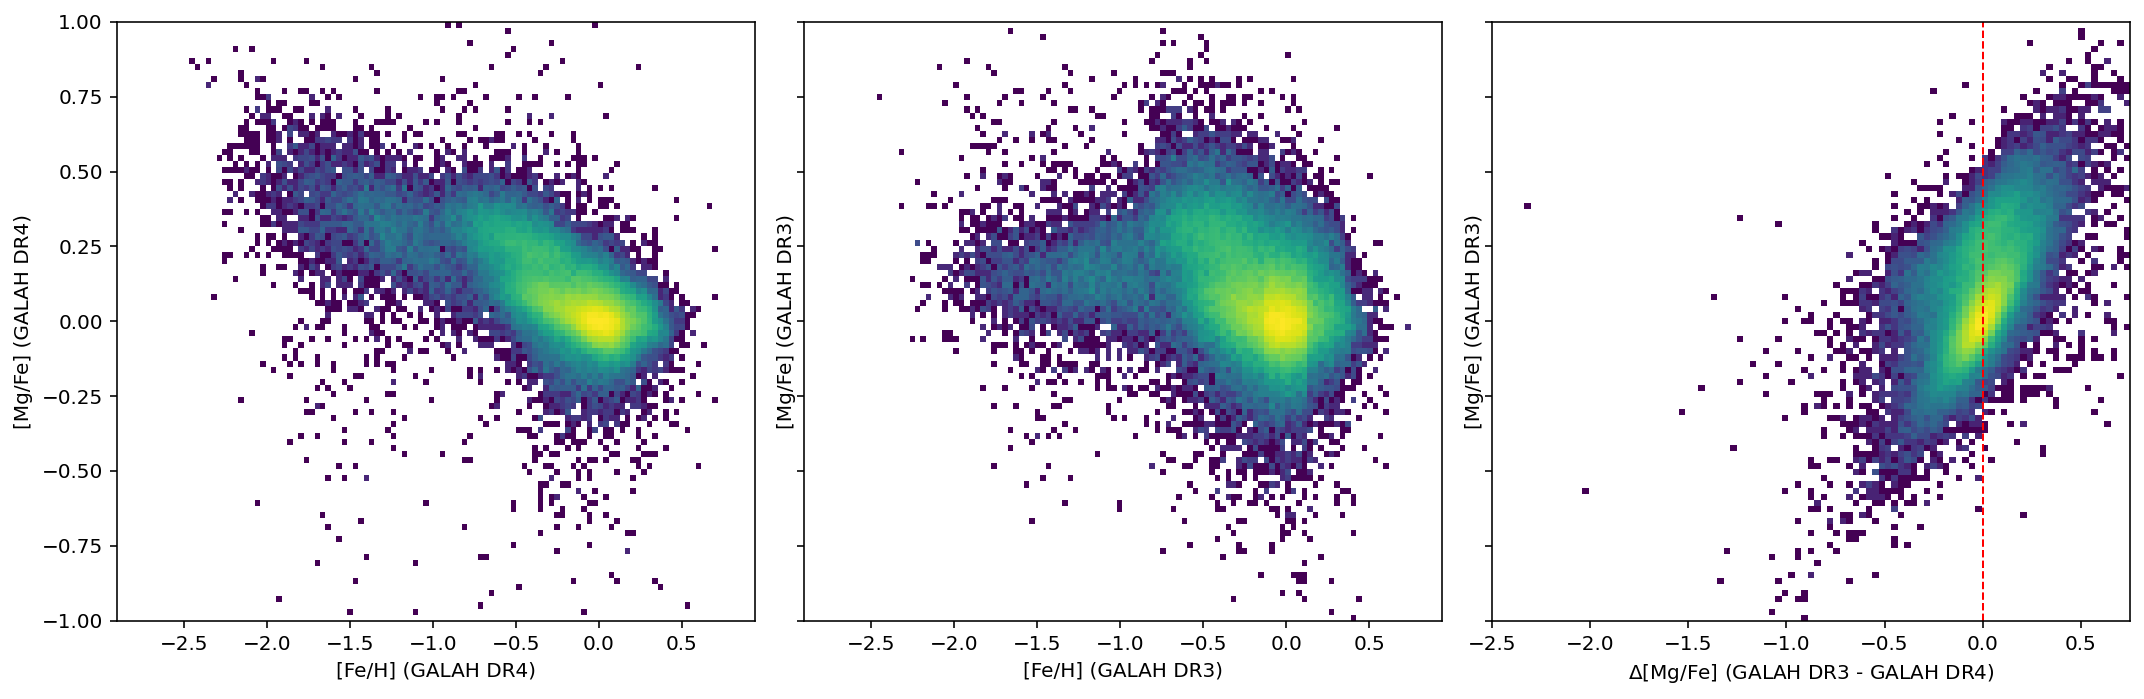

Al [0.04845897]


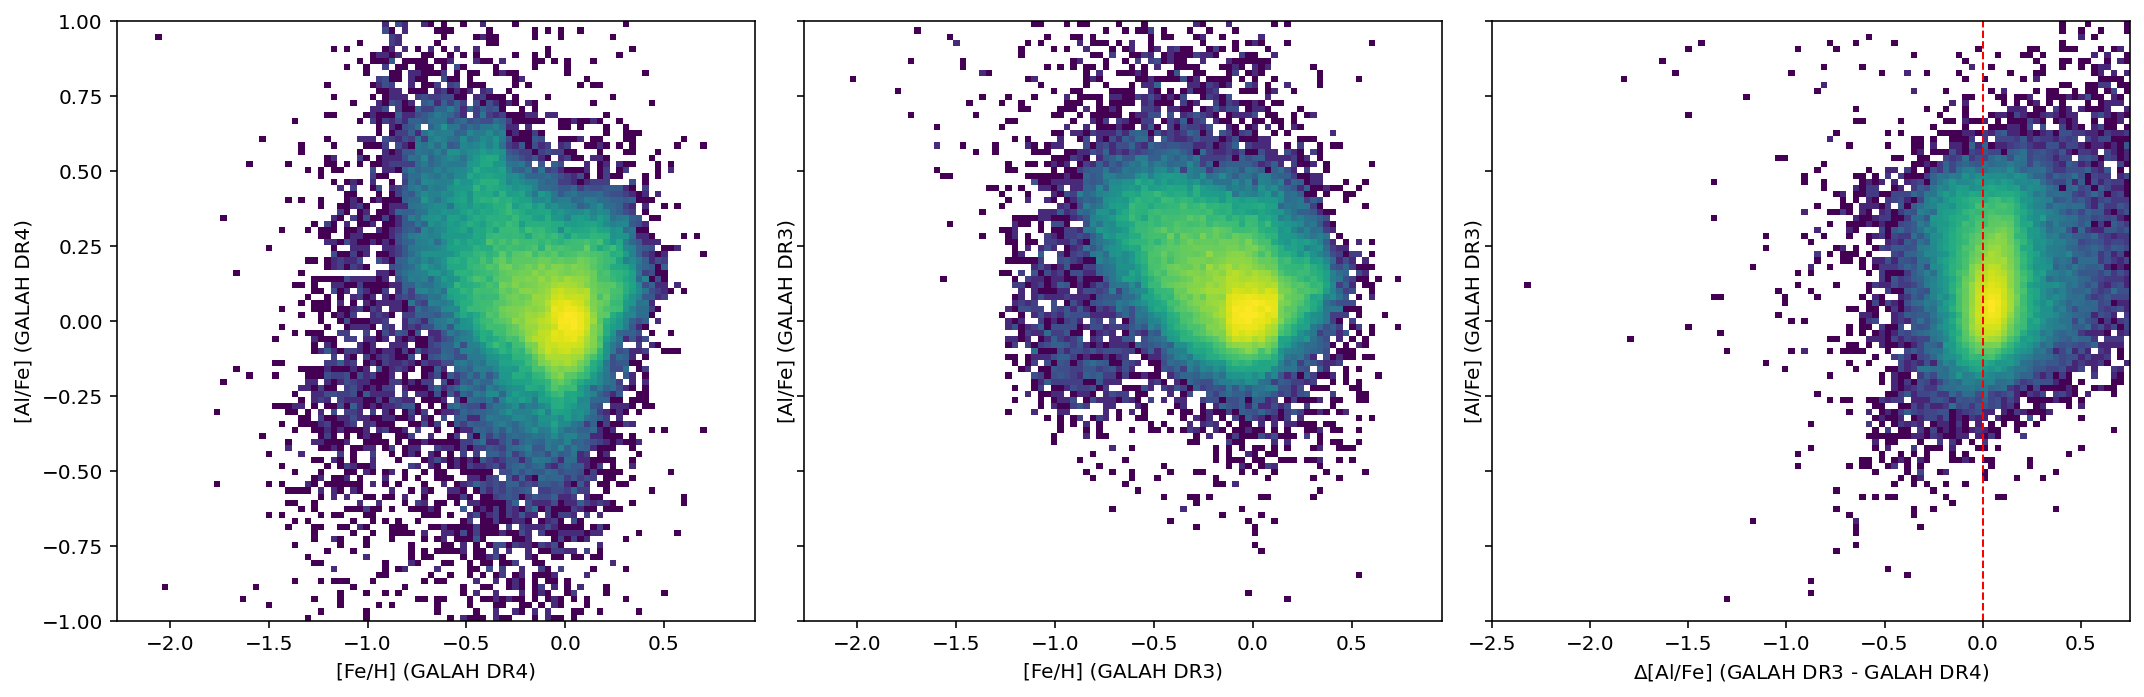

Si [-0.00737112]


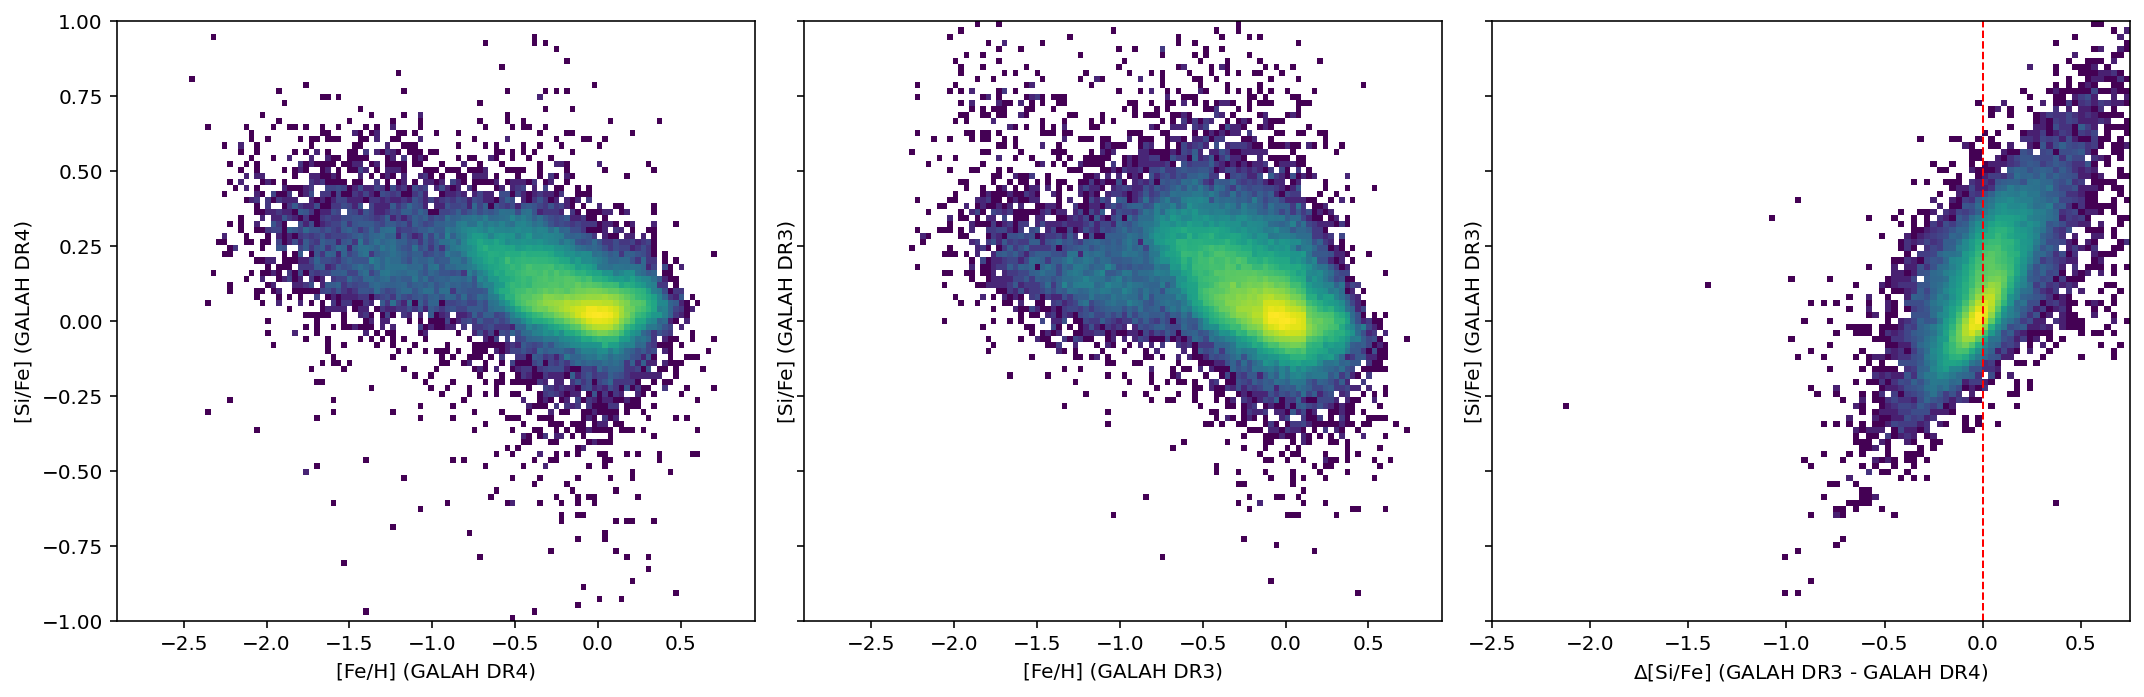

K [-0.03631365]


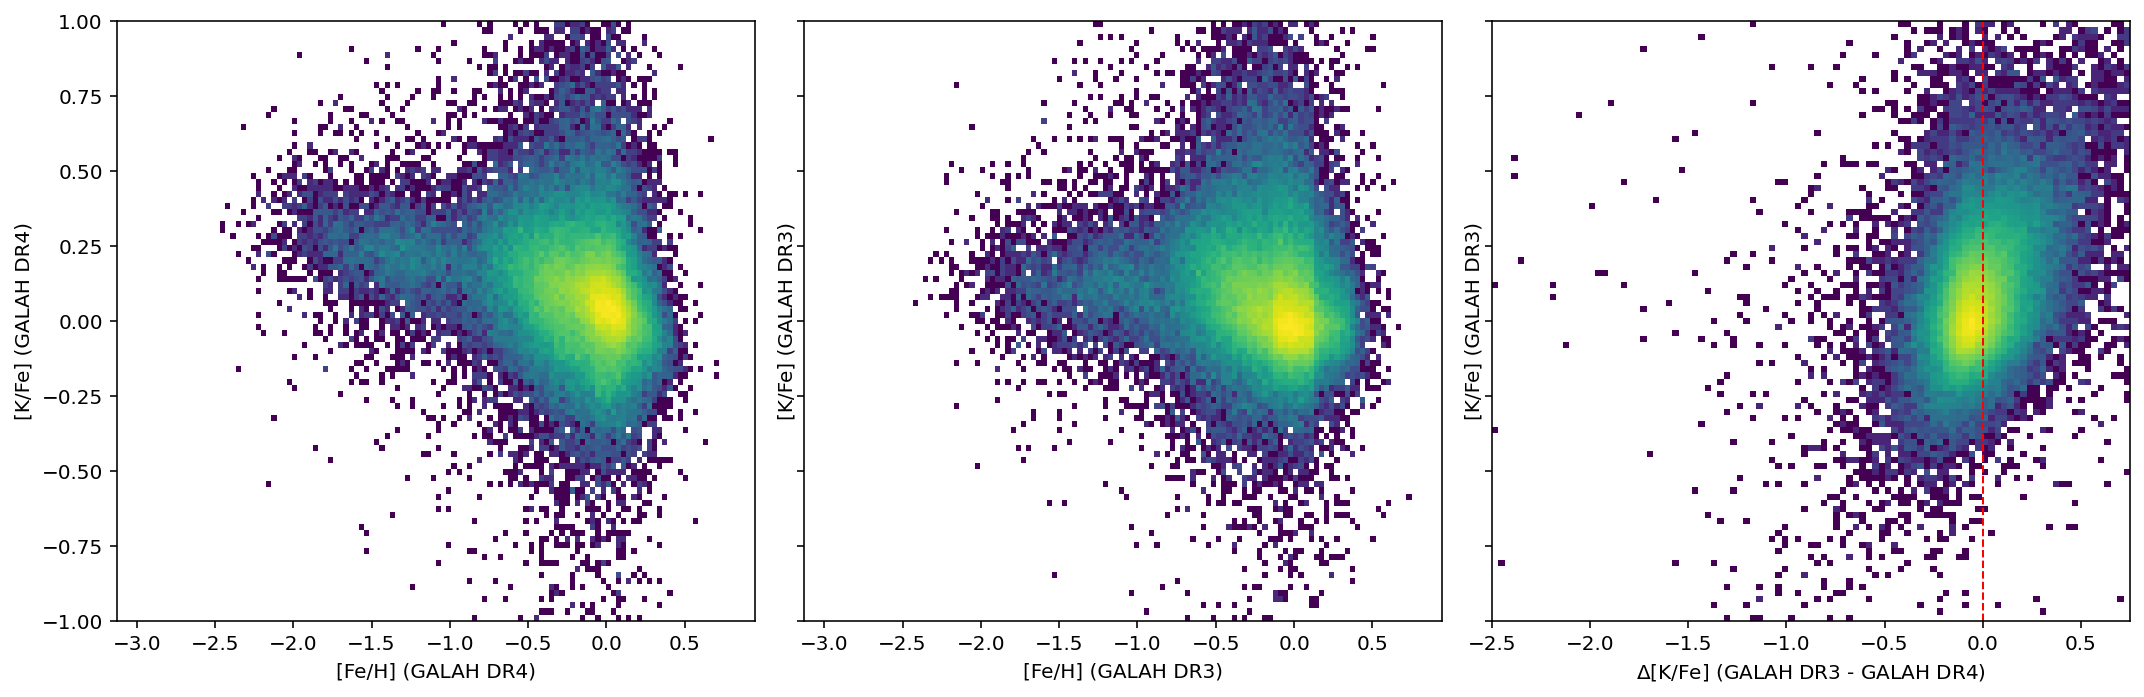

Ca [0.05846004]


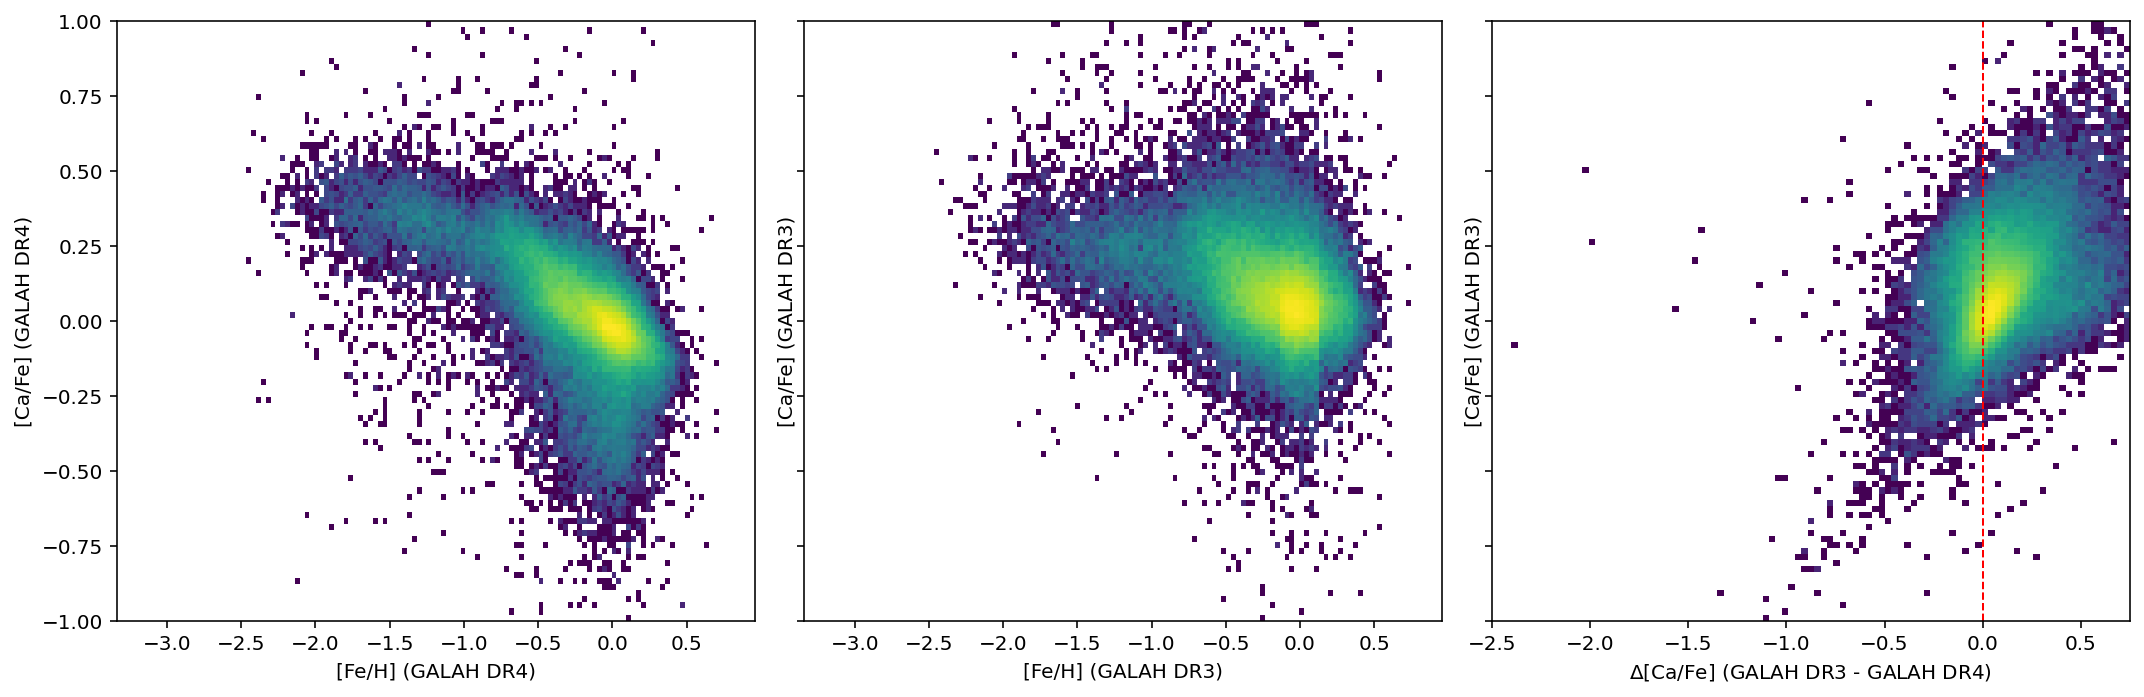

Sc [0.03410451]


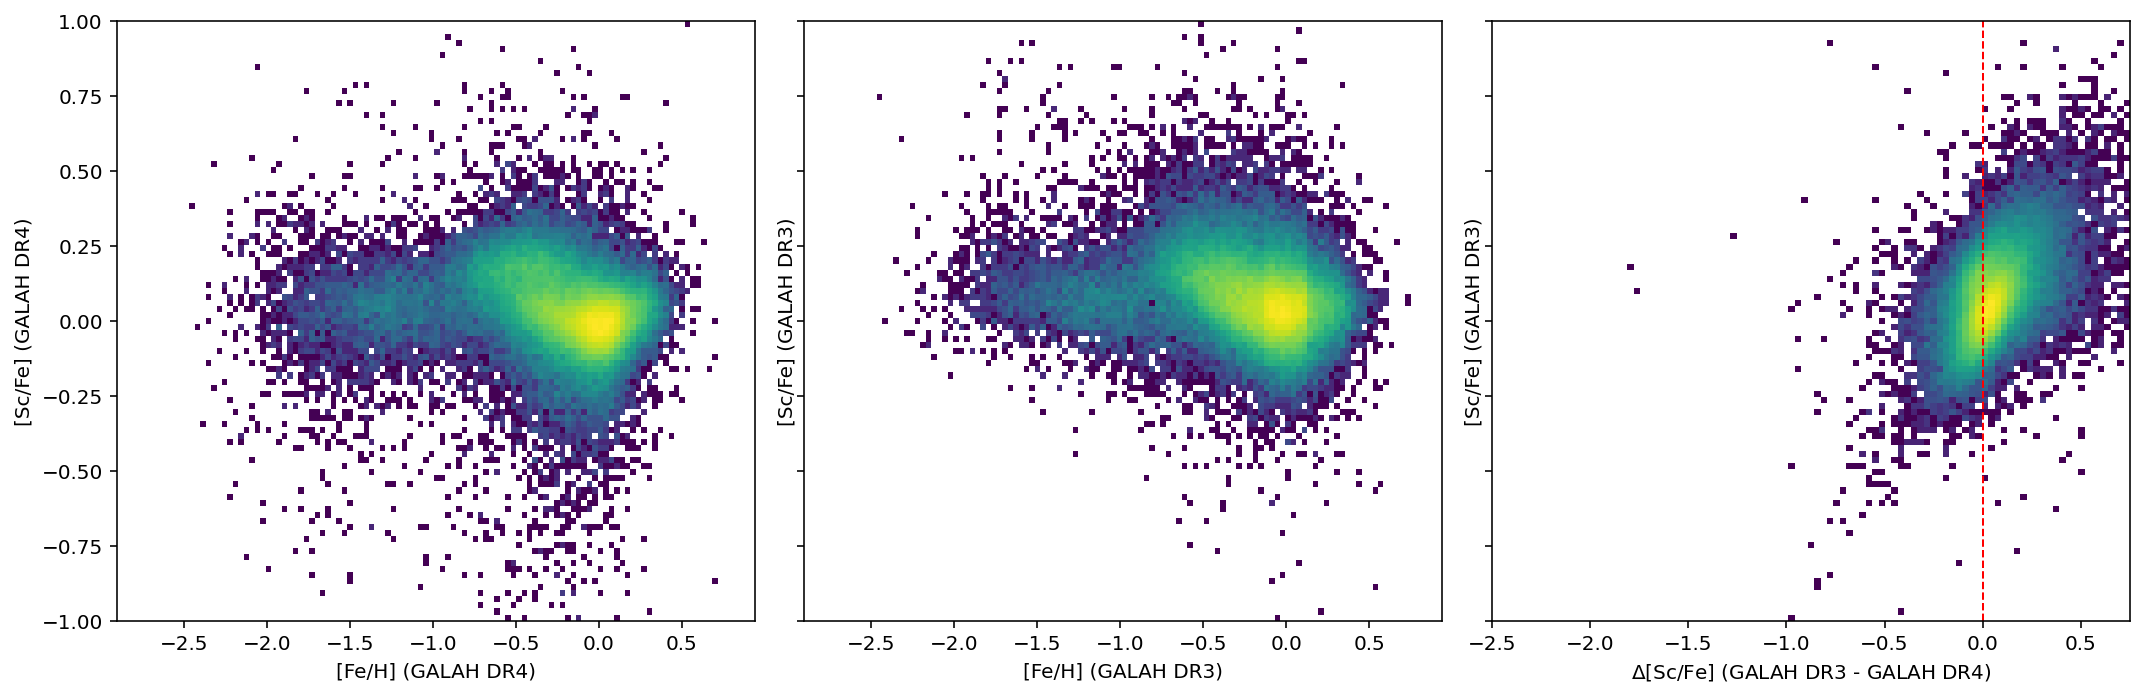

Ti [0.02397921]


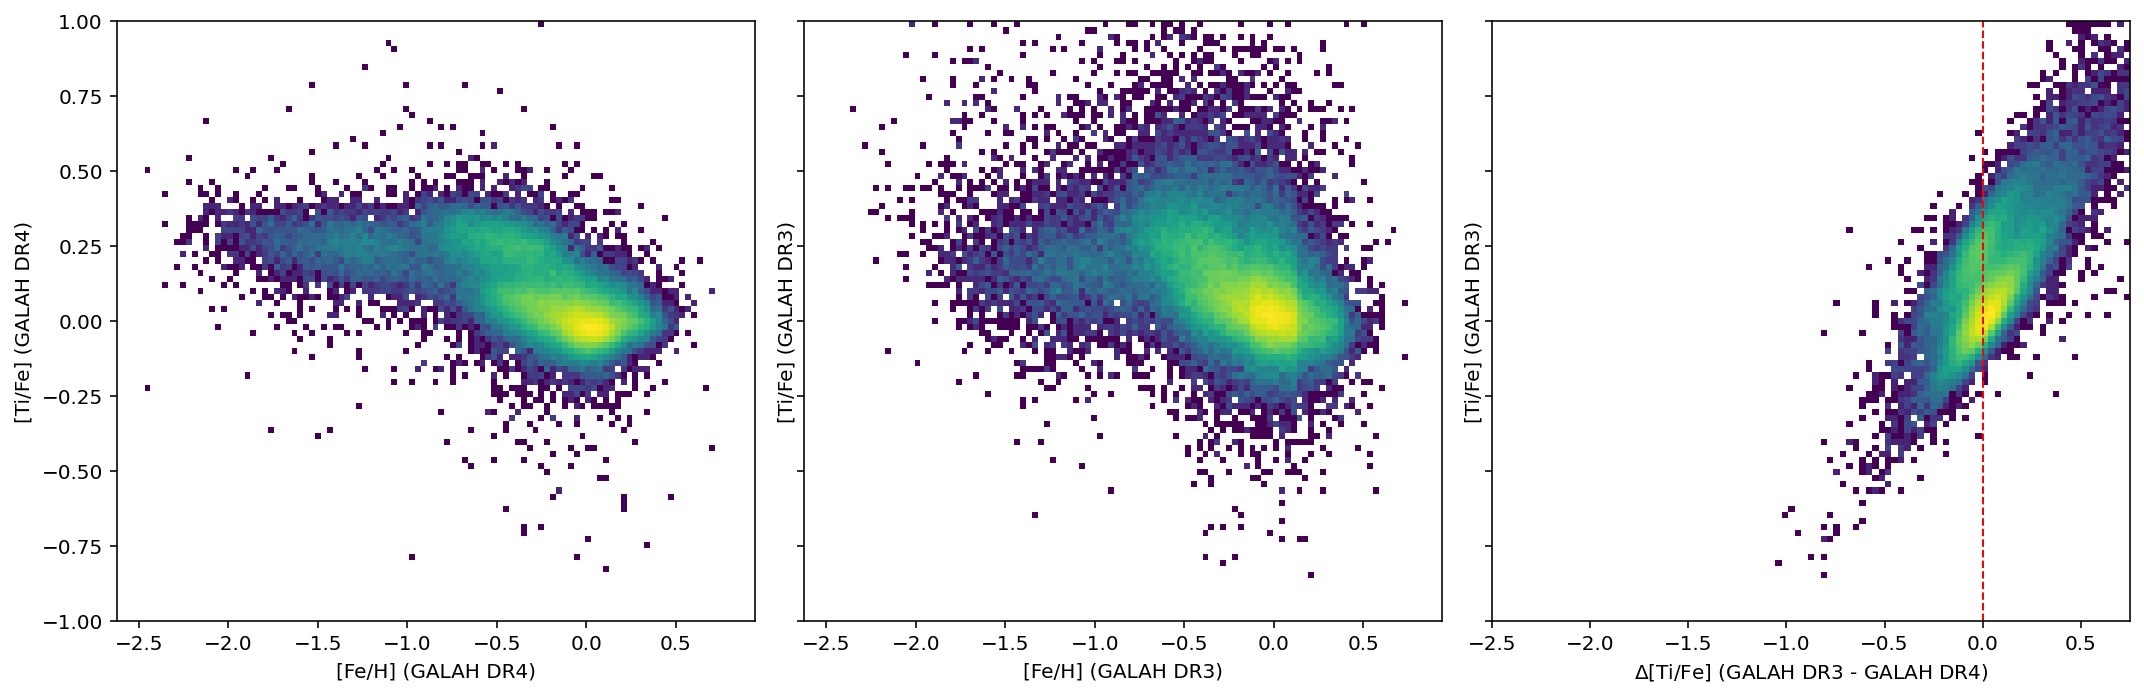

V [-0.01317107]


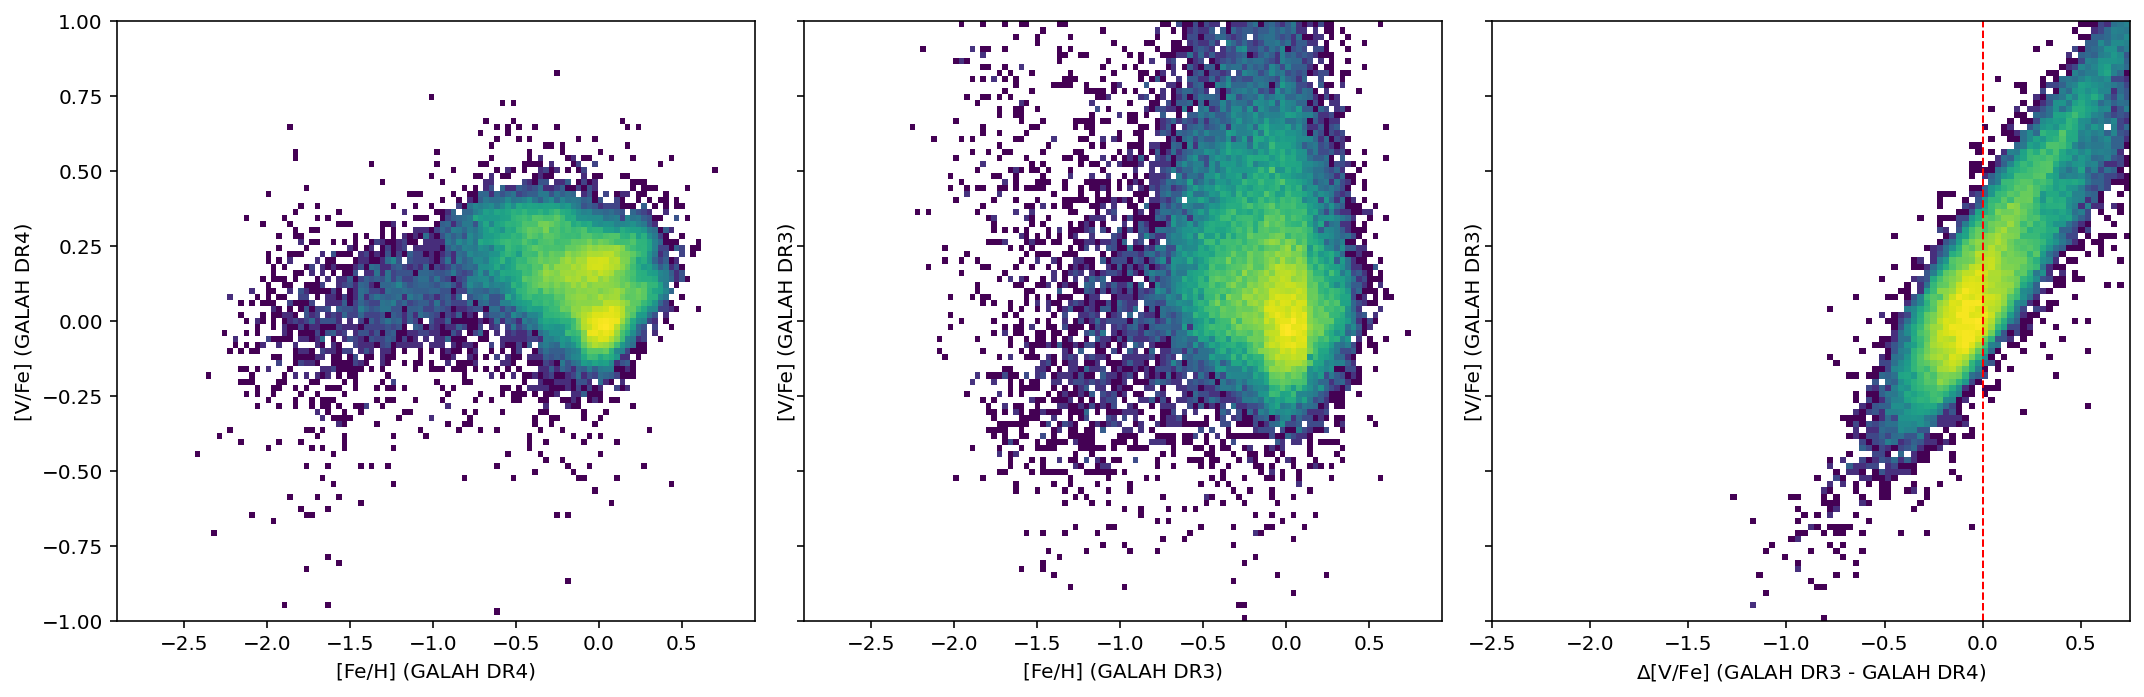

Cr [-0.03109801]


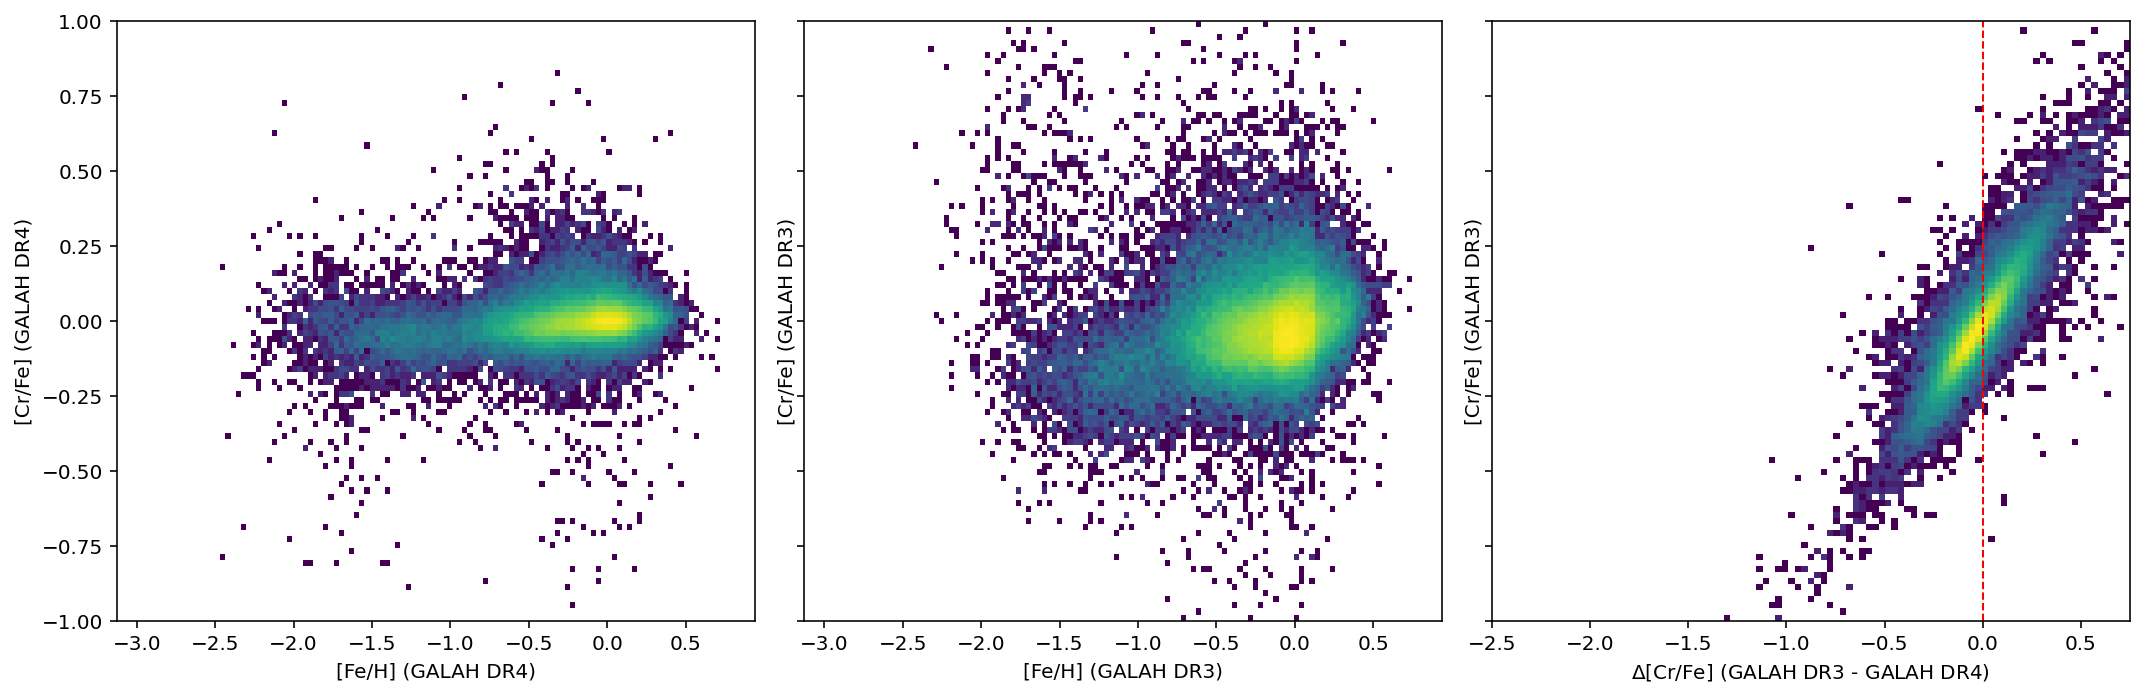

Mn [0.03161182]


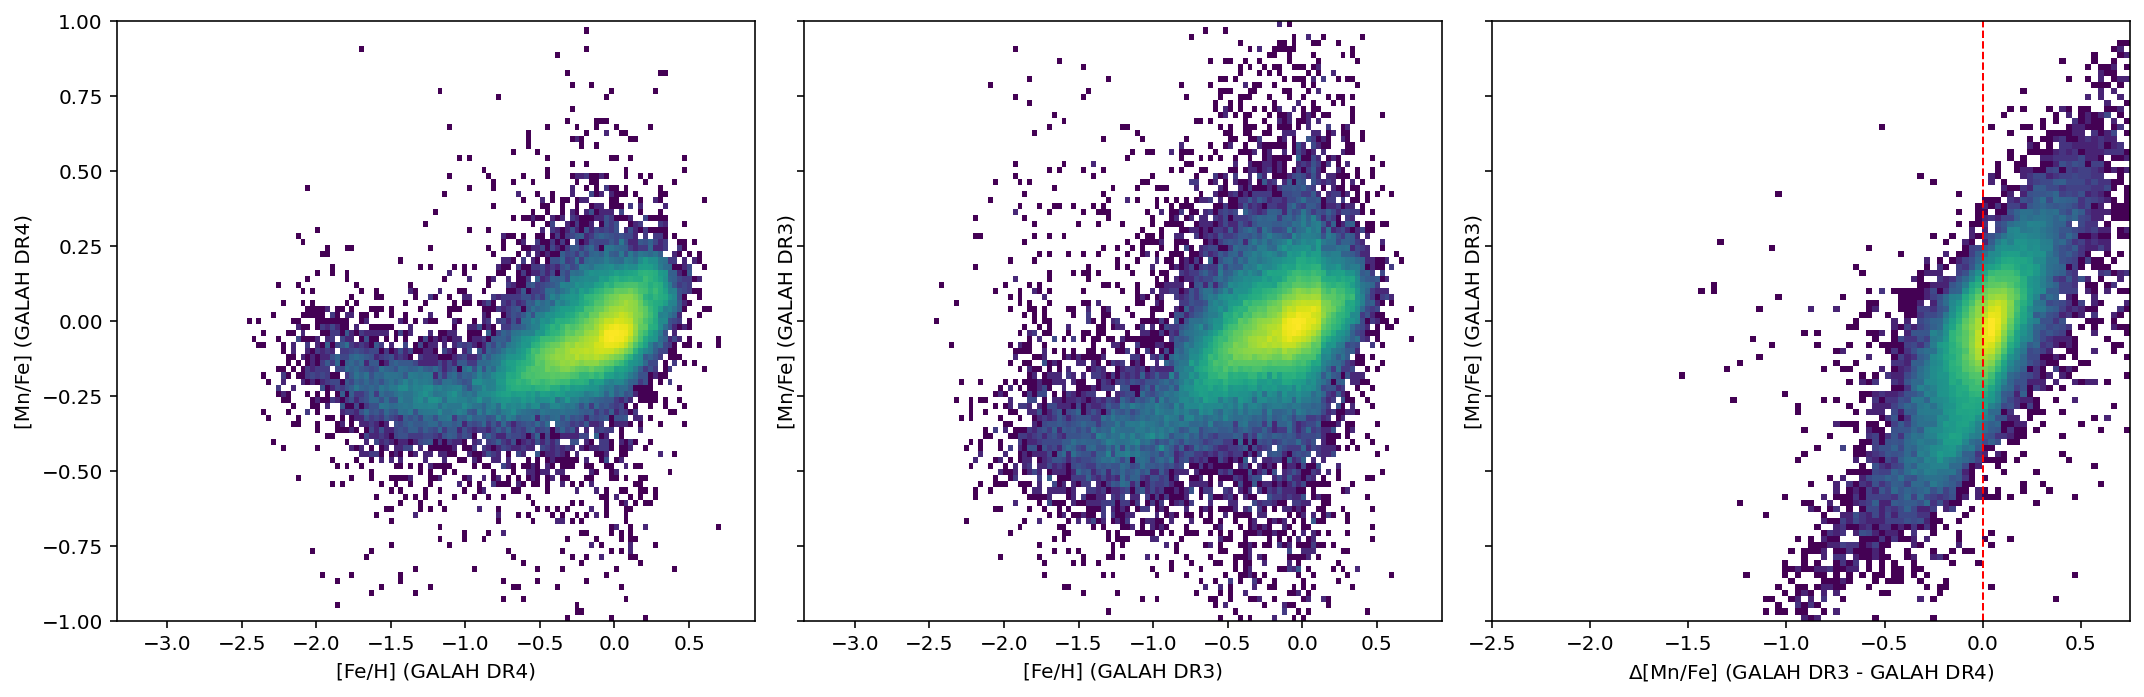

Co [0.04990833]


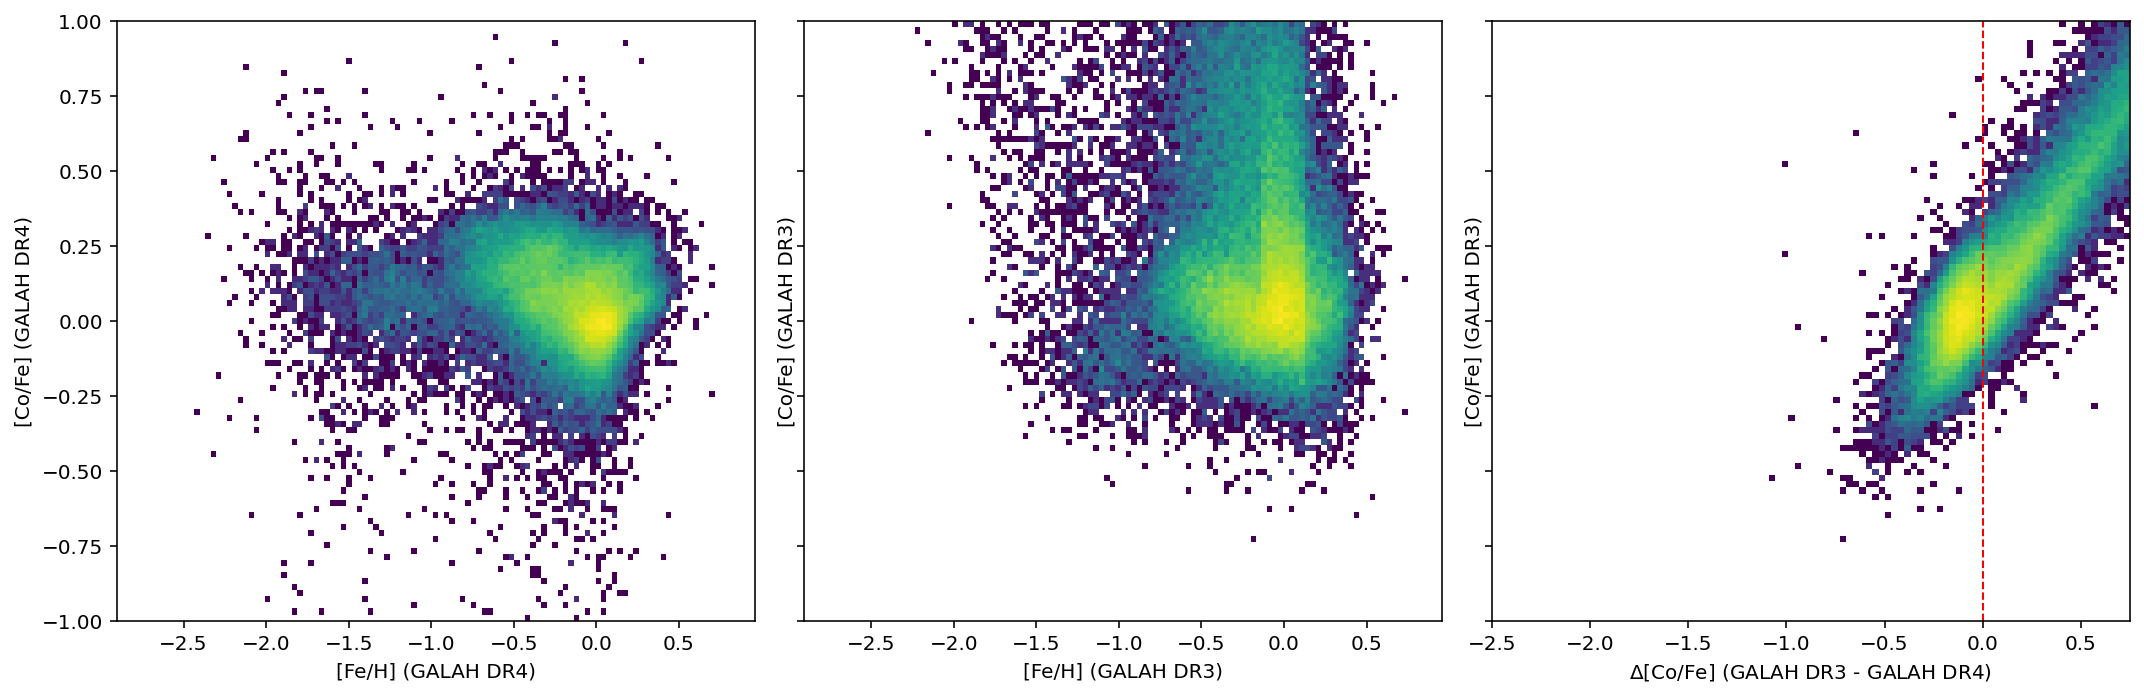

Ni [0.00233322]


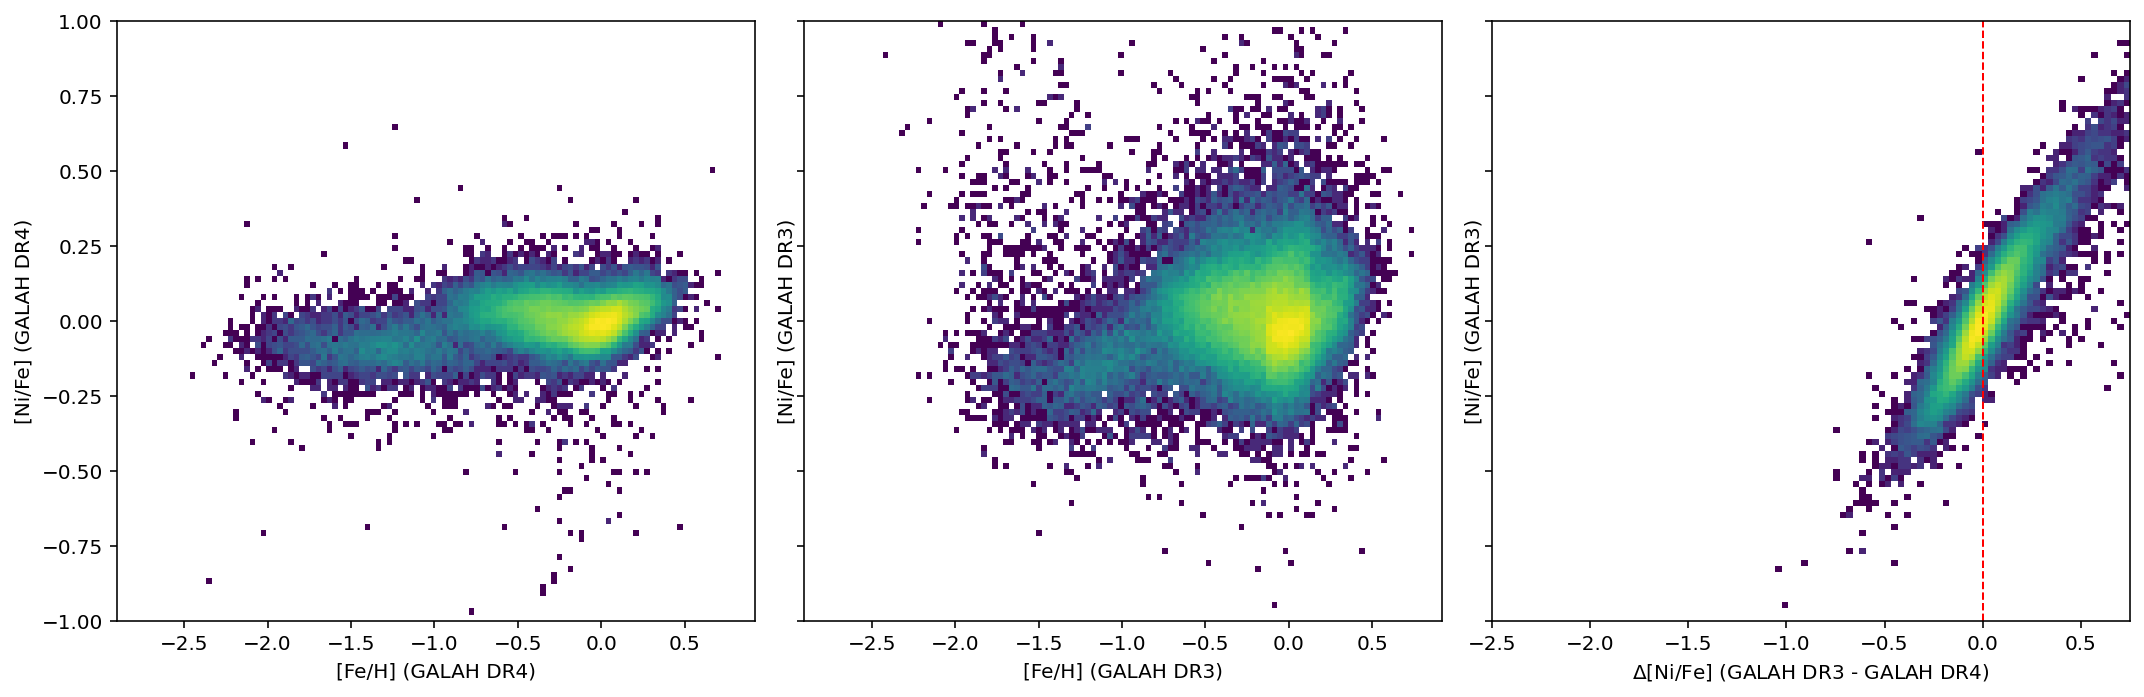

Cu [0.03978021]


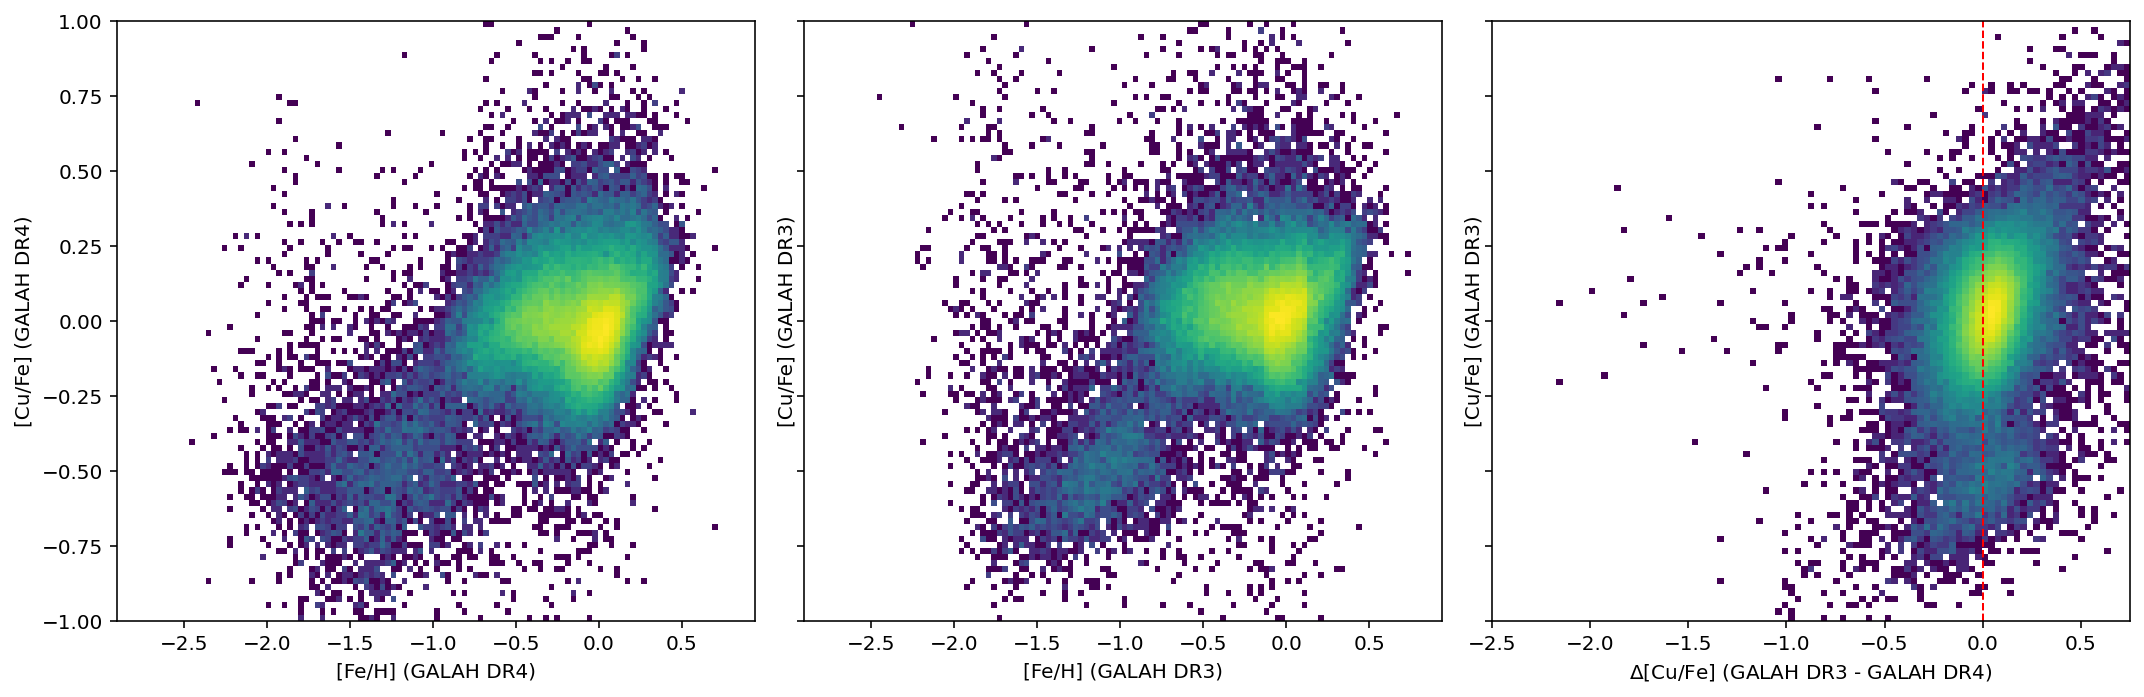

Zn [0.03221914]


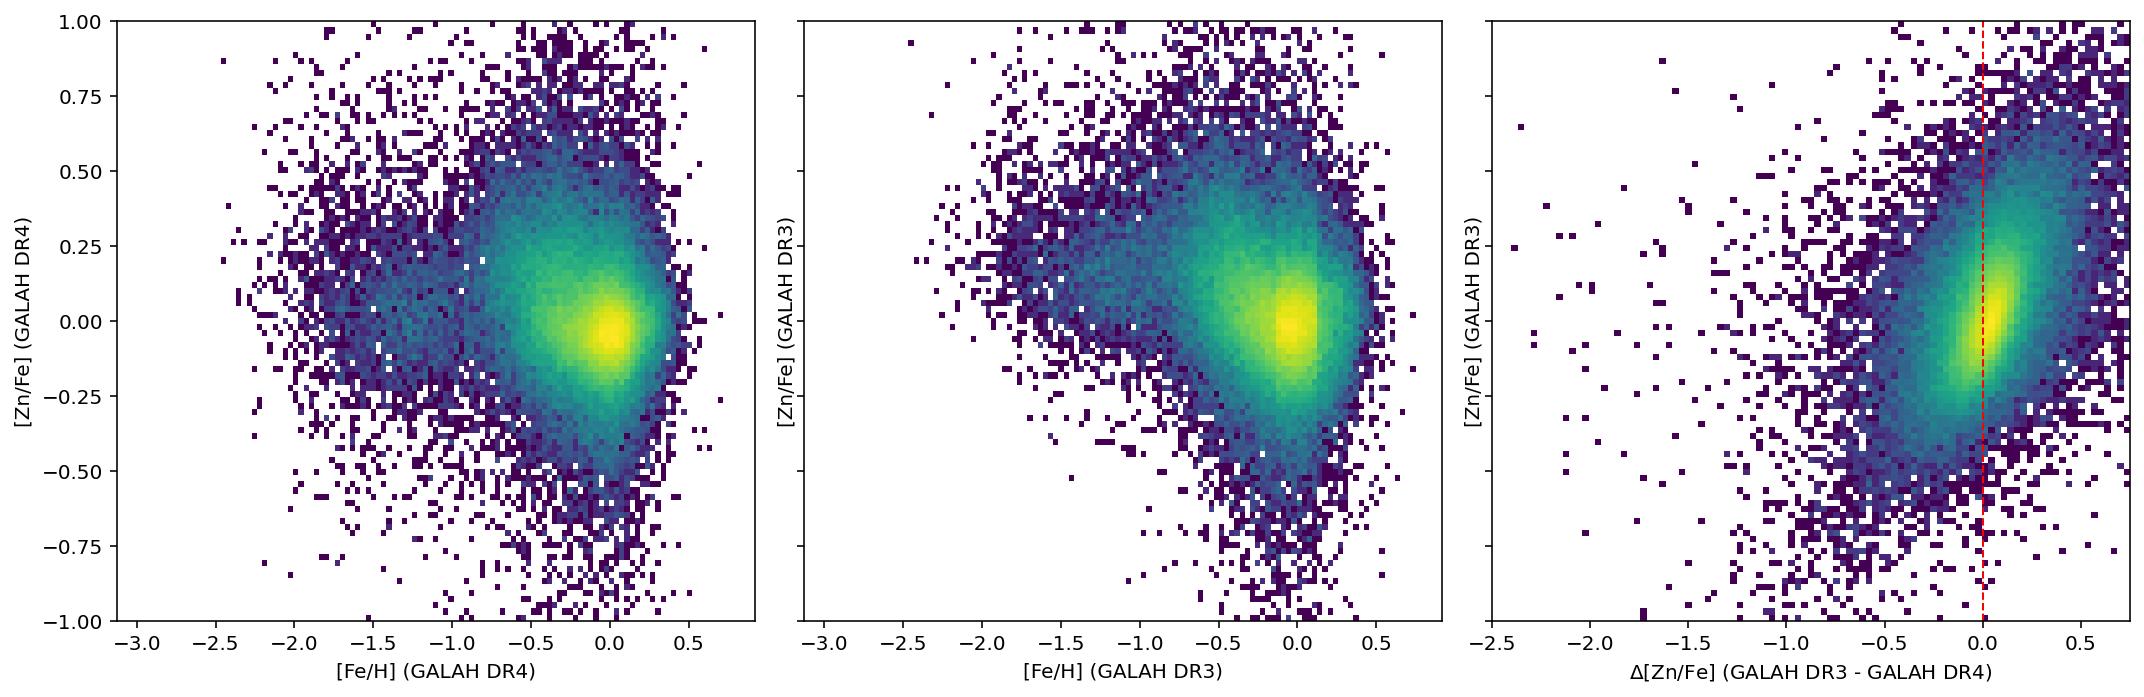

Rb [-0.34185153]


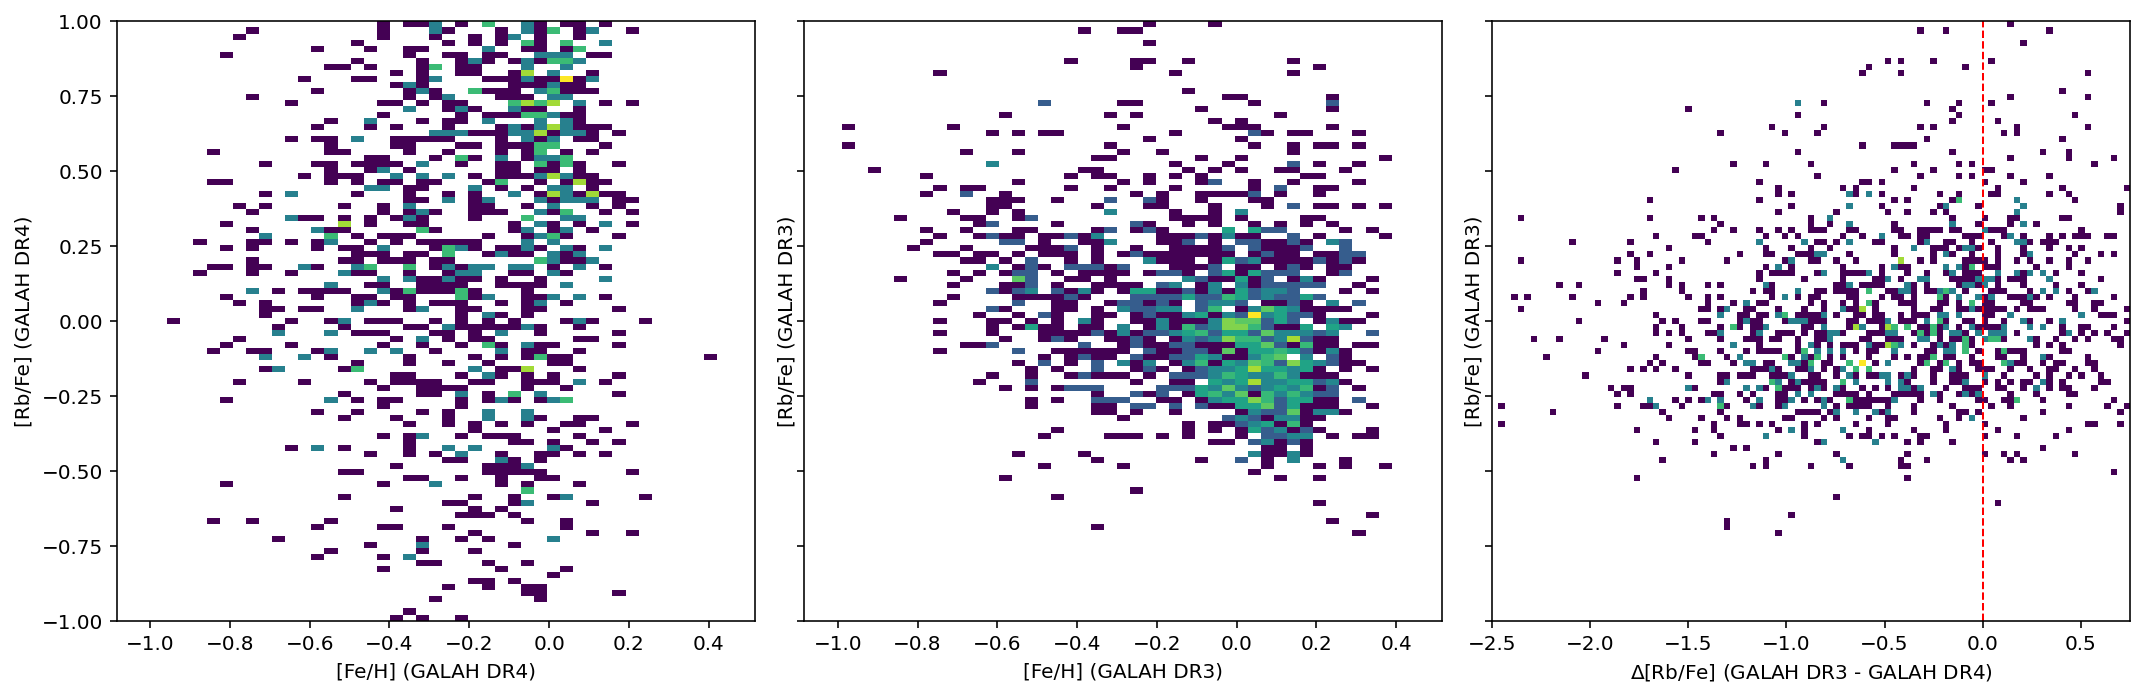

Sr [0.24129522]


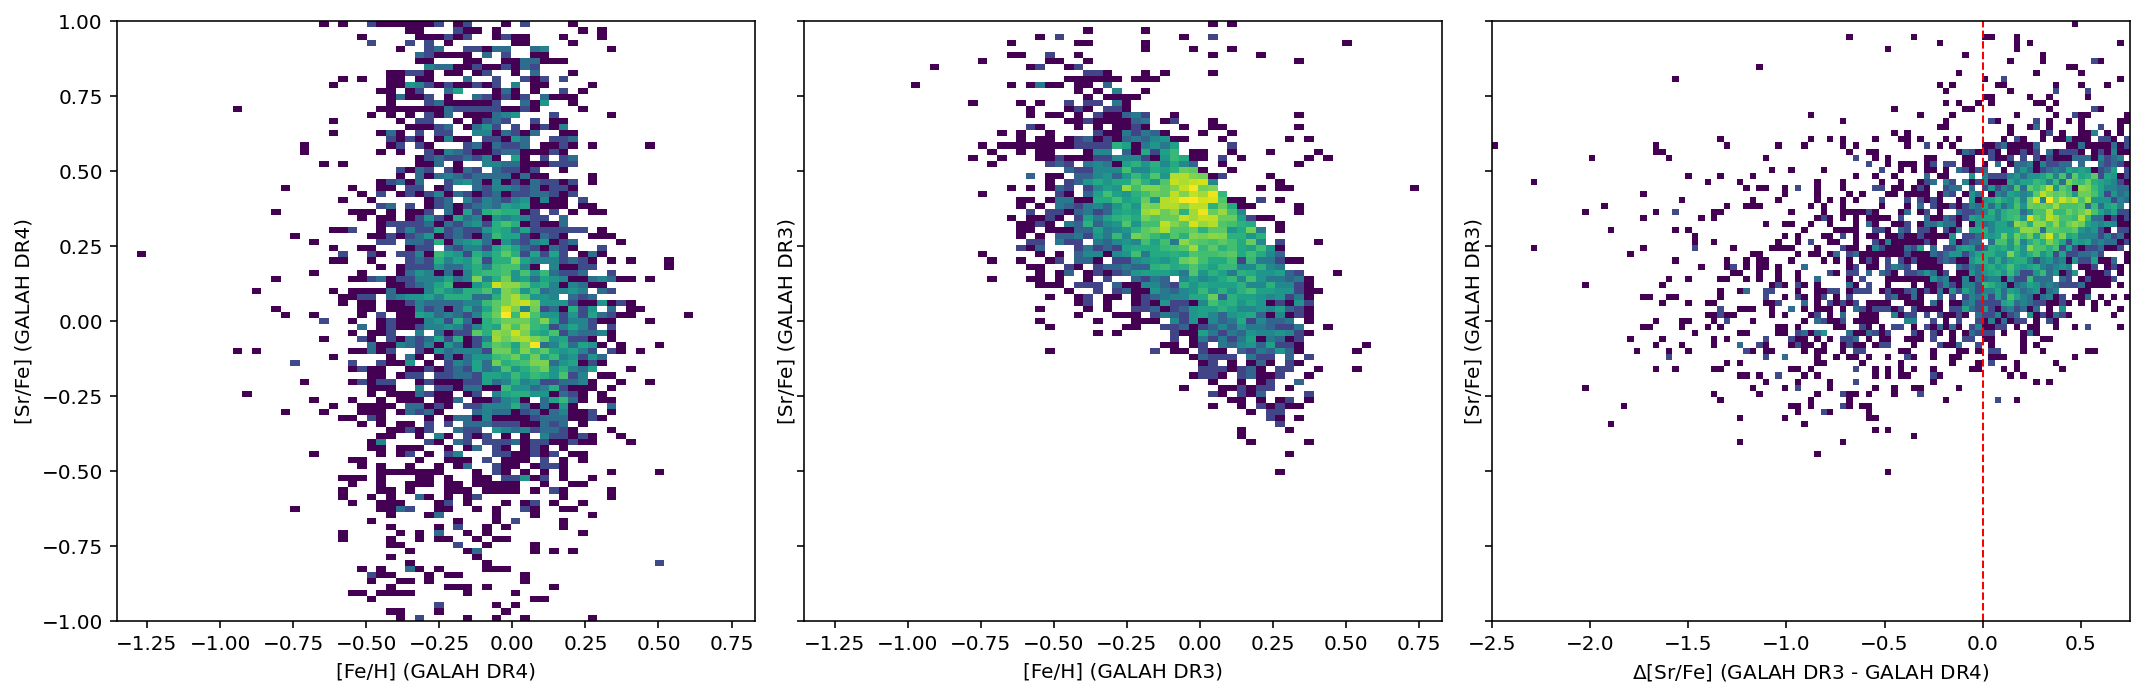

Y [-0.00993468]


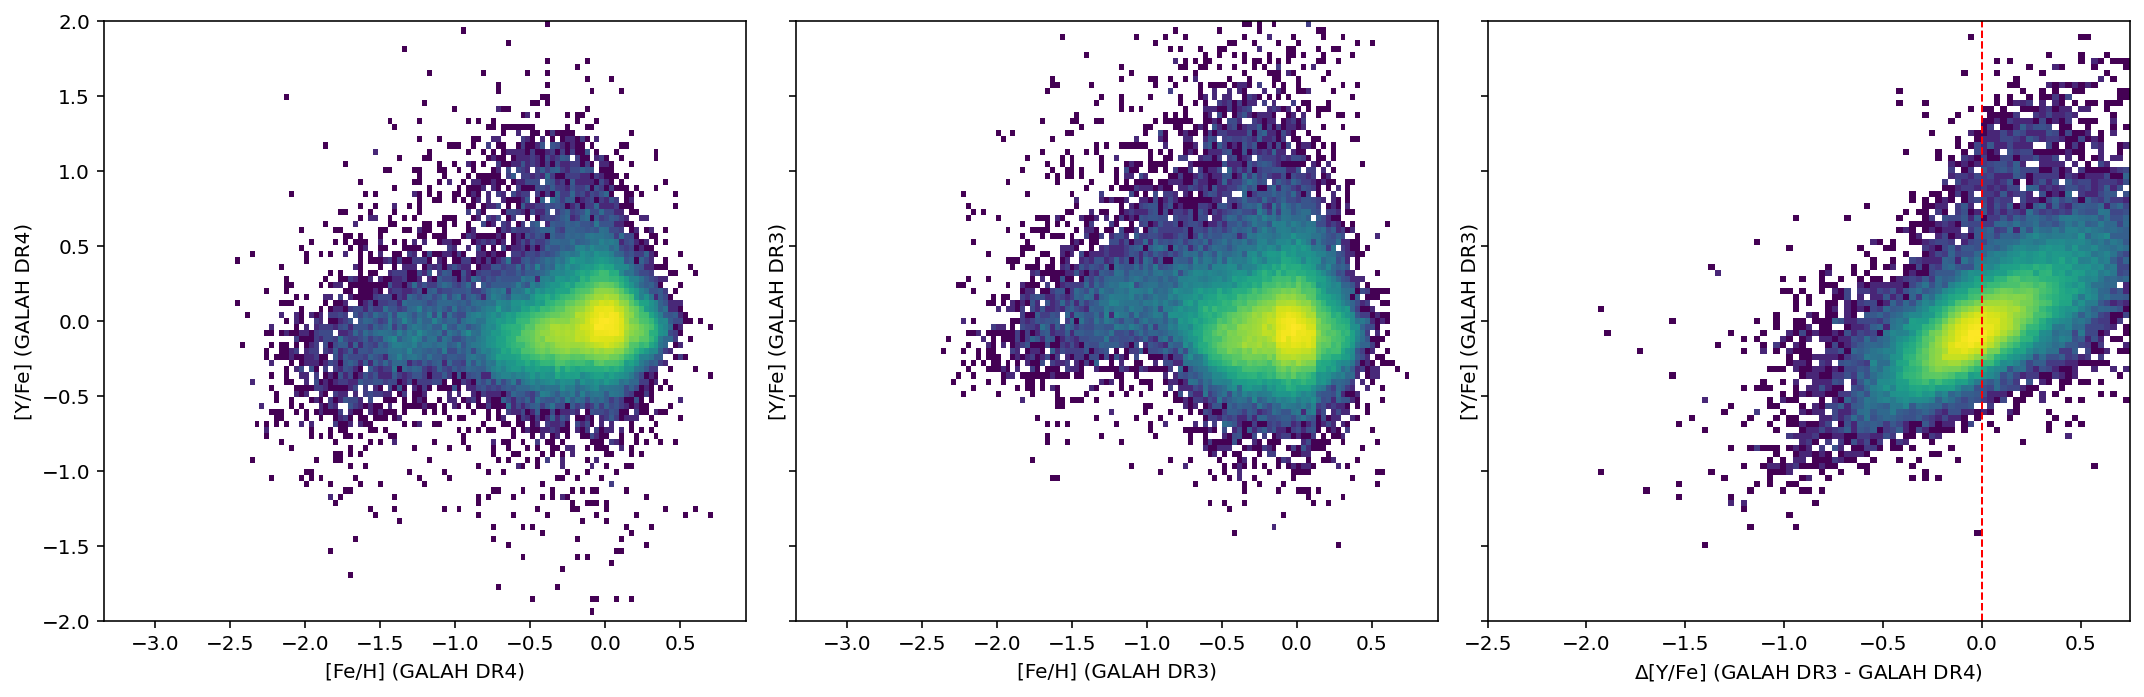

Zr [-0.07839383]


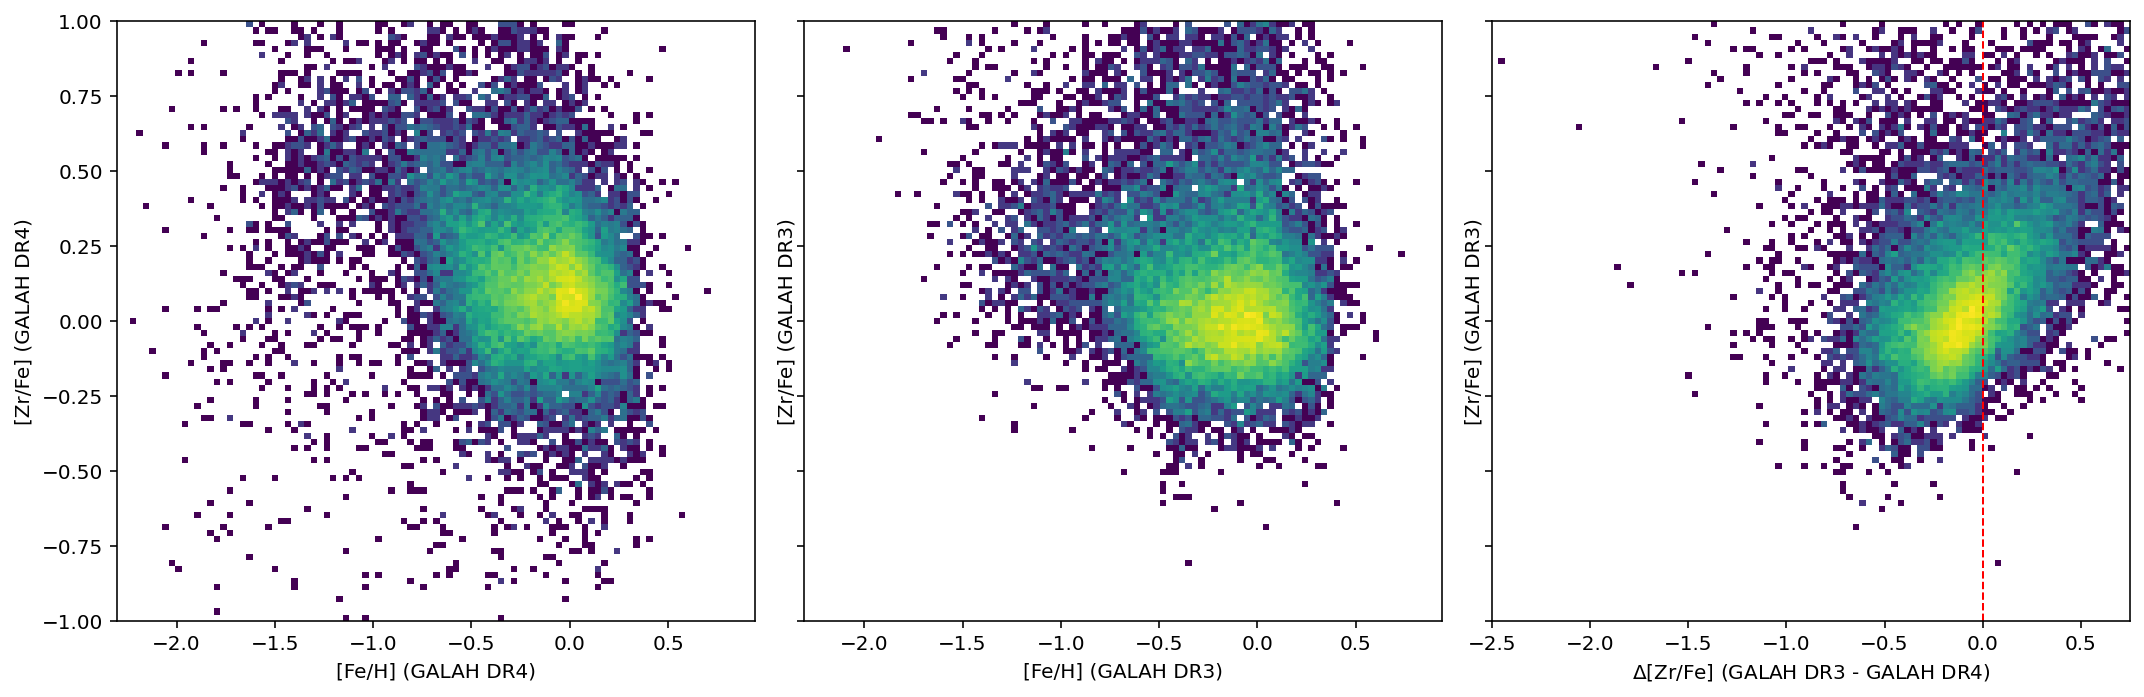

Mo [0.11591439]


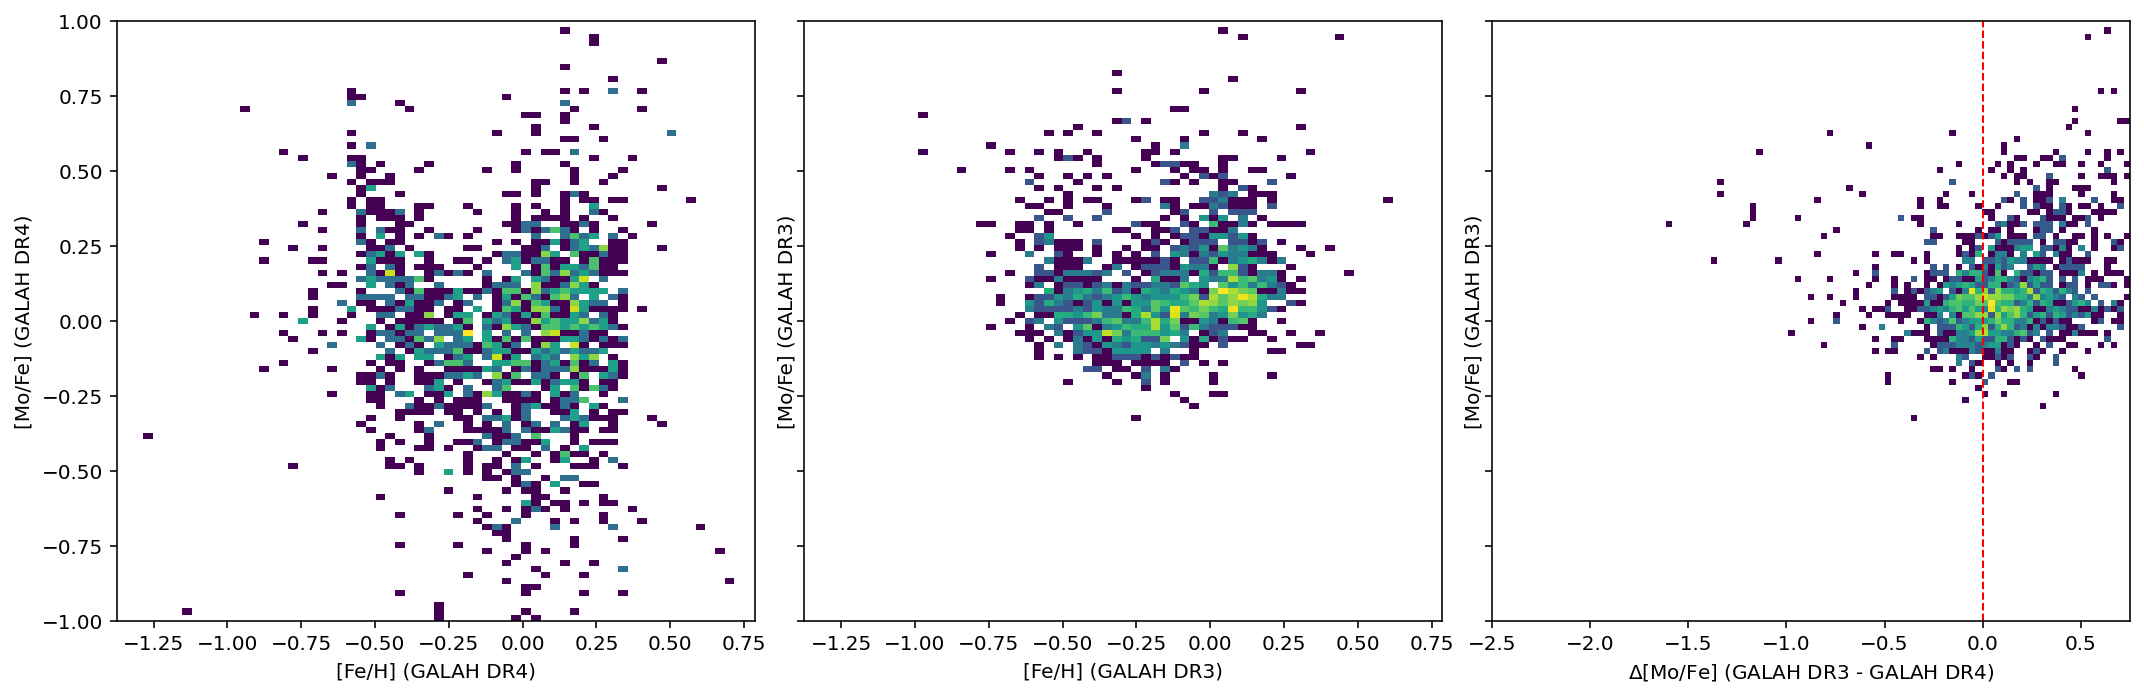

Ru [0.21341484]


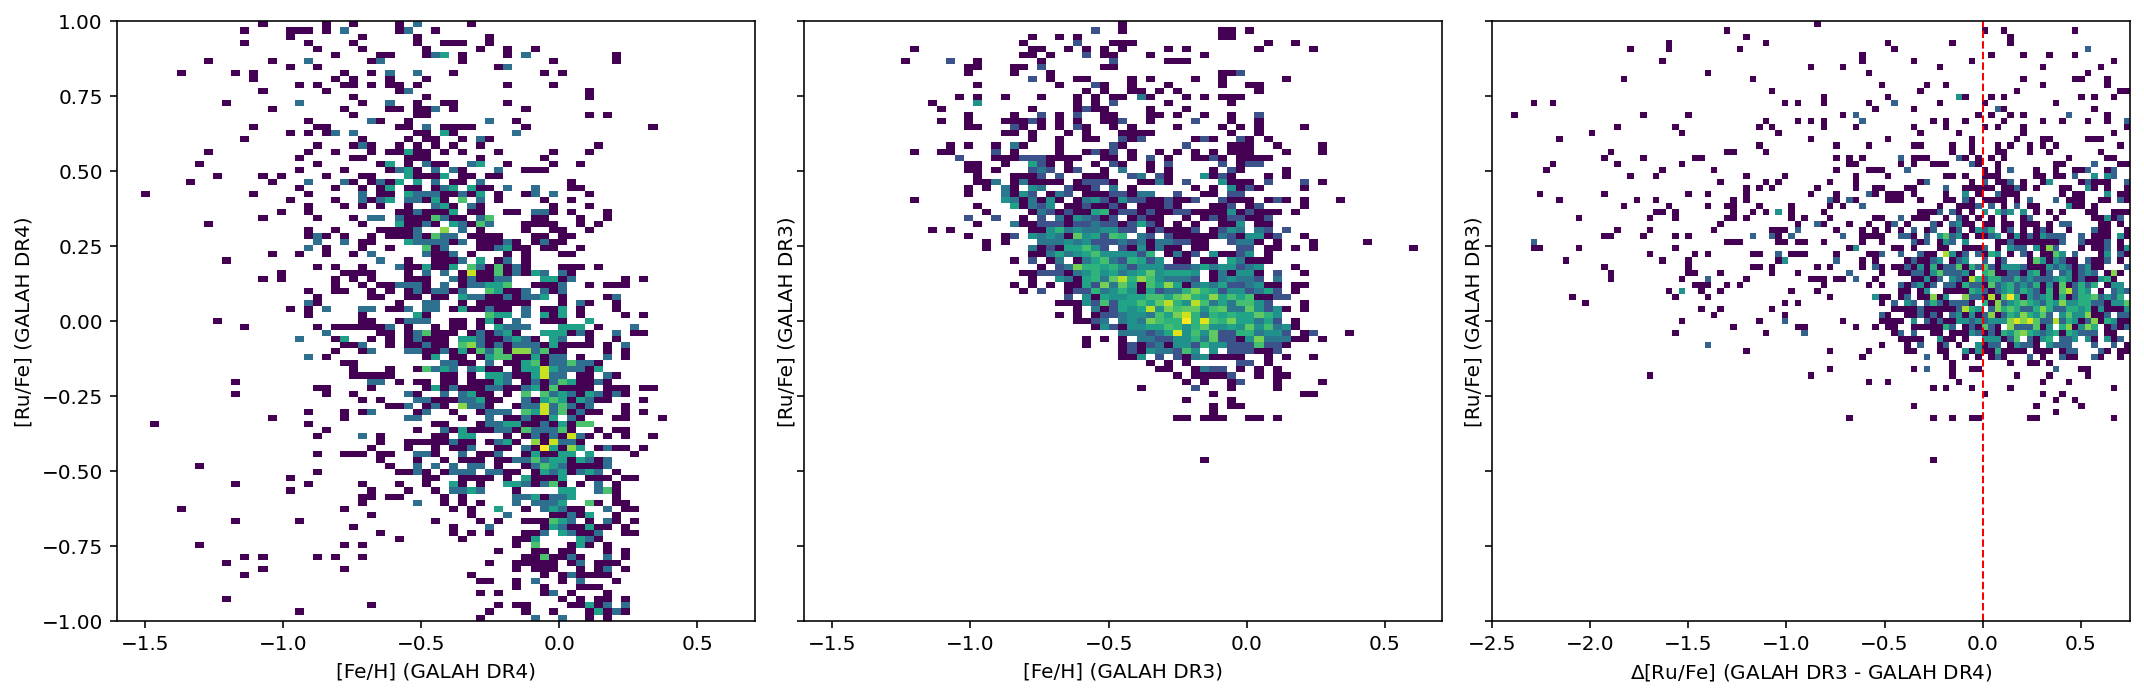

Ba [-0.02250375]


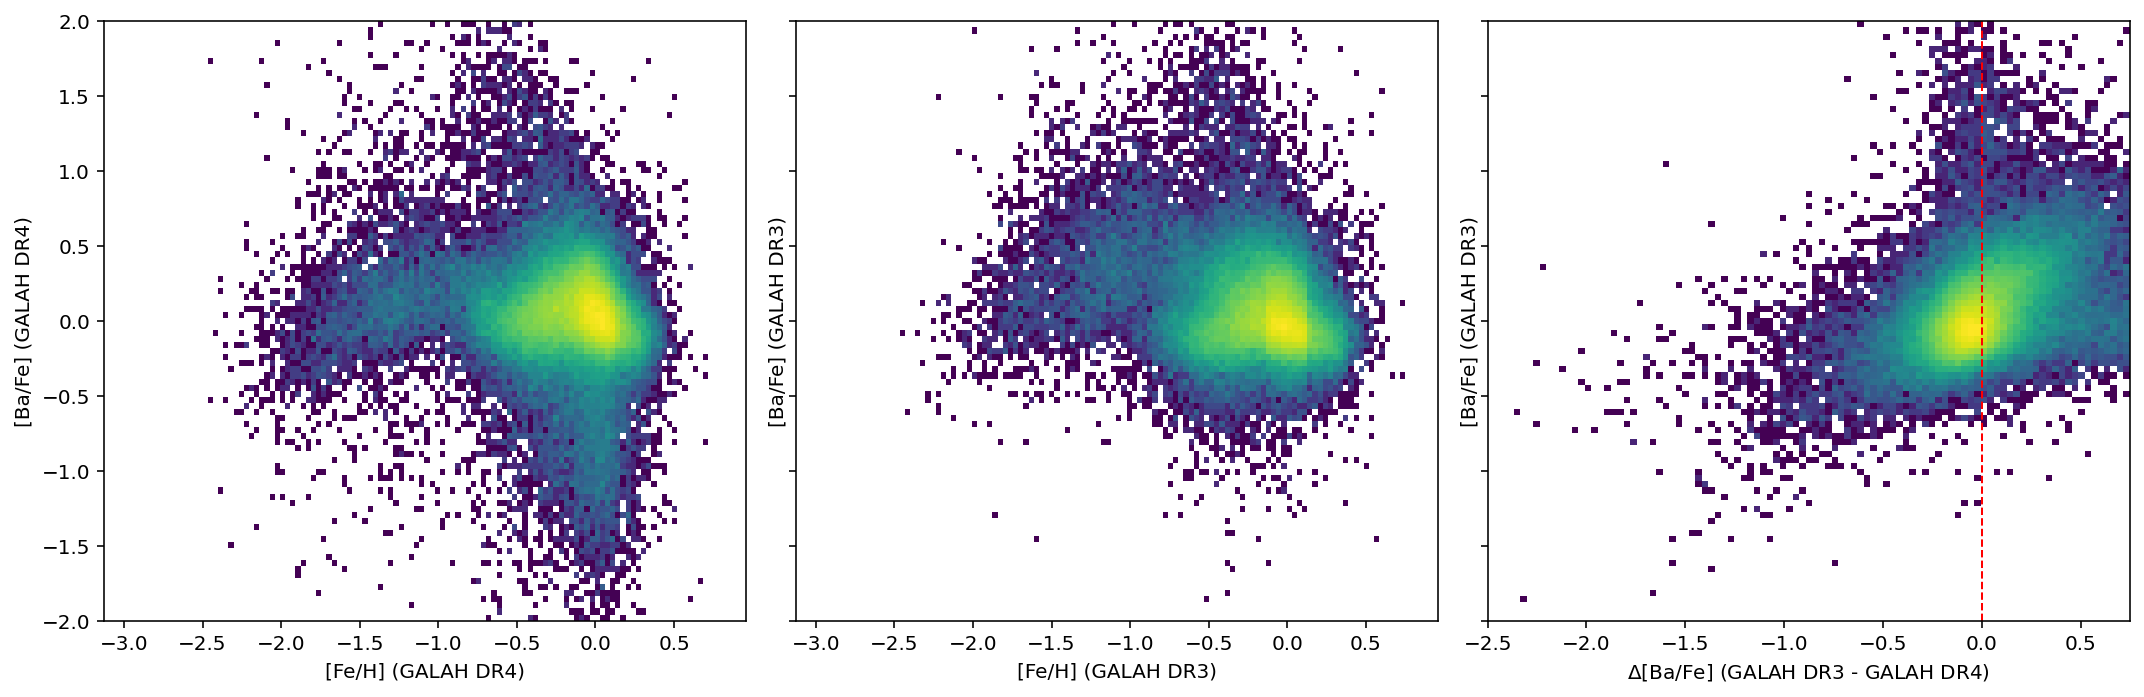

La [-0.05320033]


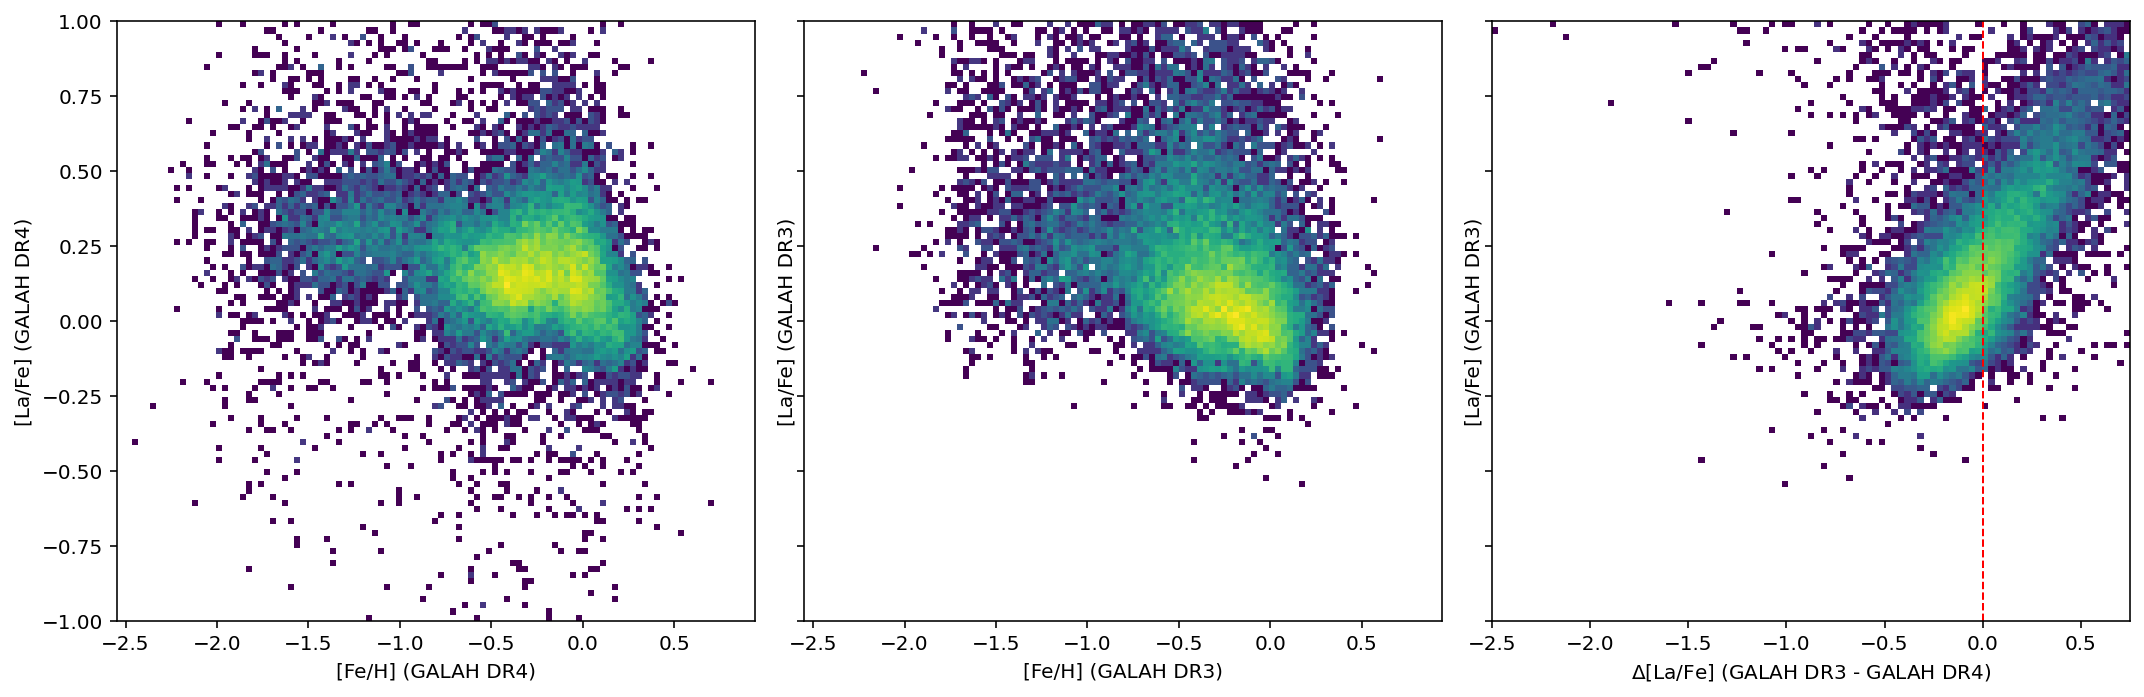

Ce [0.06356813]


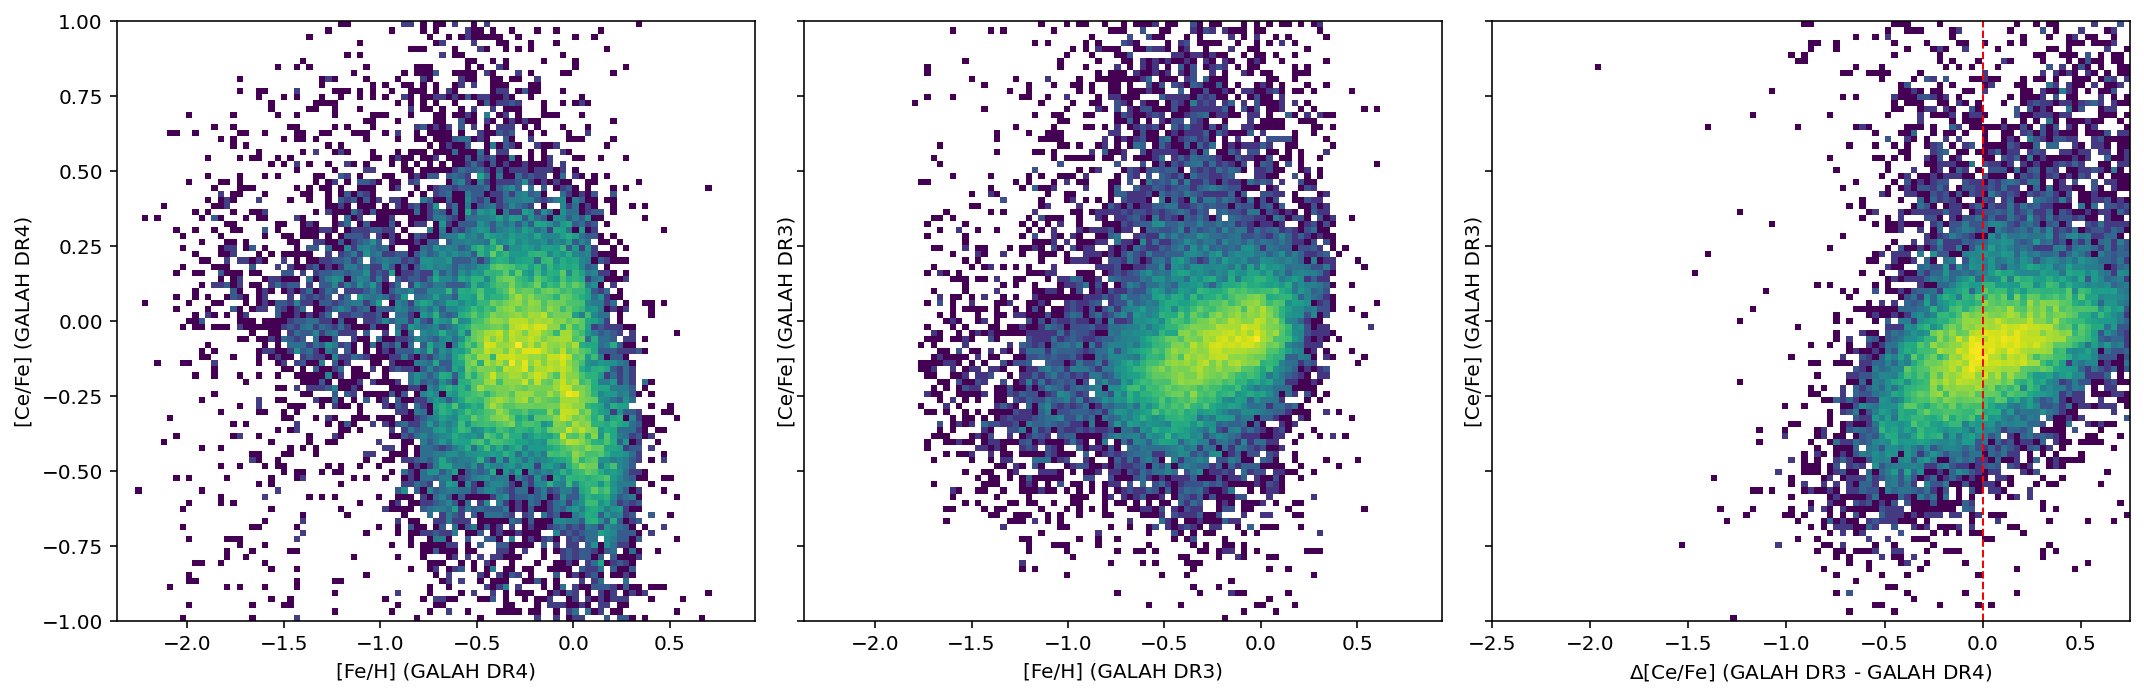

Nd [0.27014145]


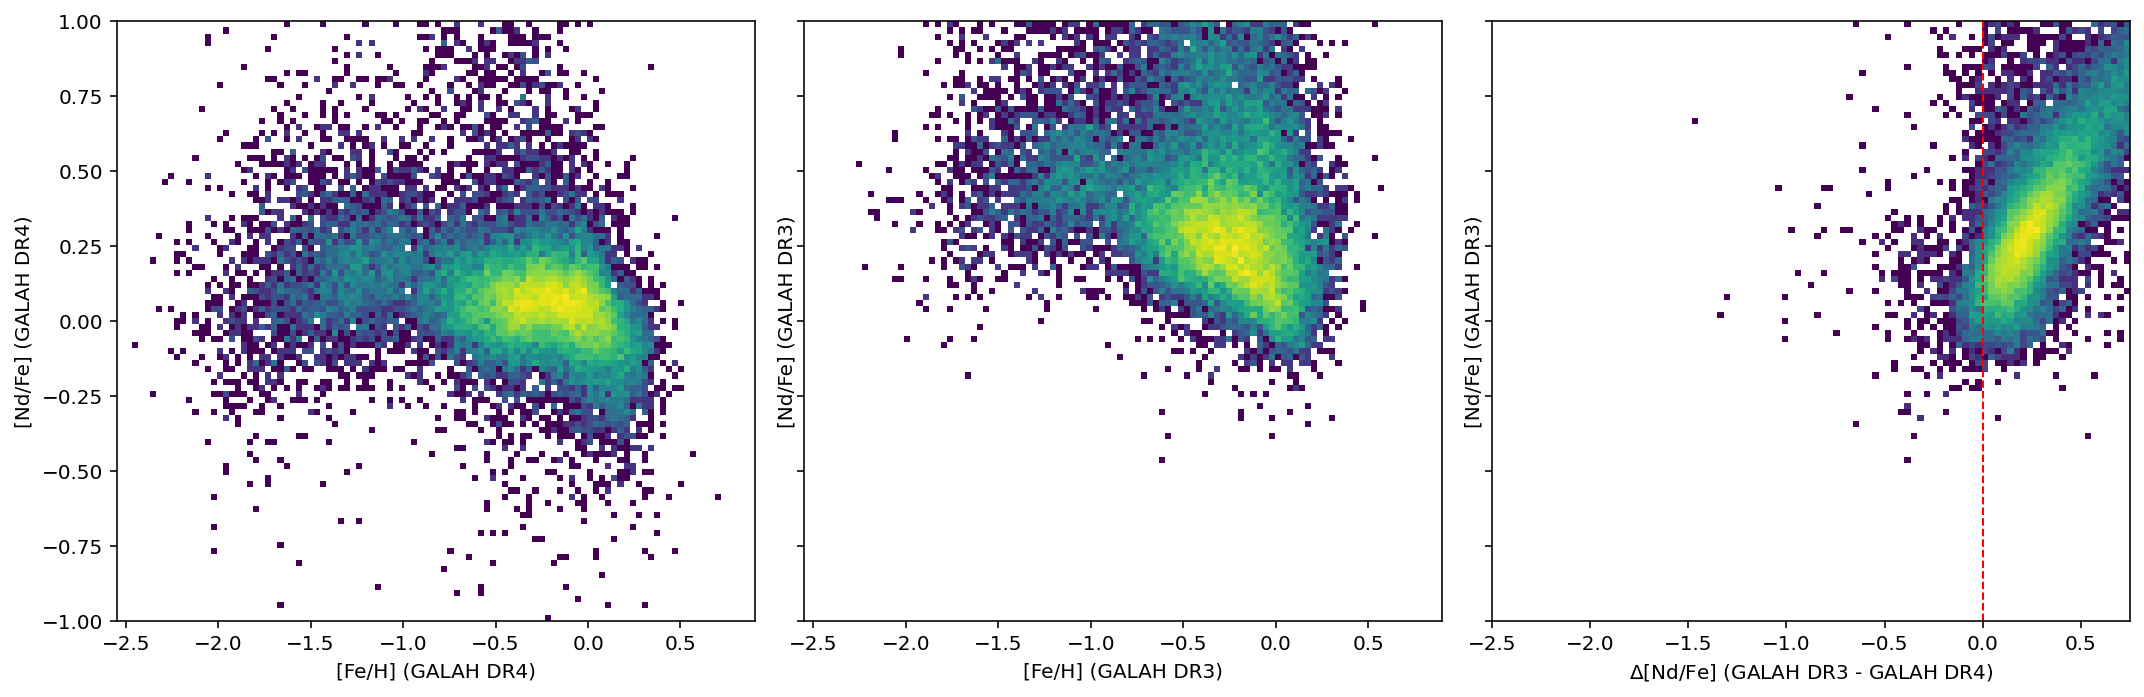

Sm [-0.0434347]


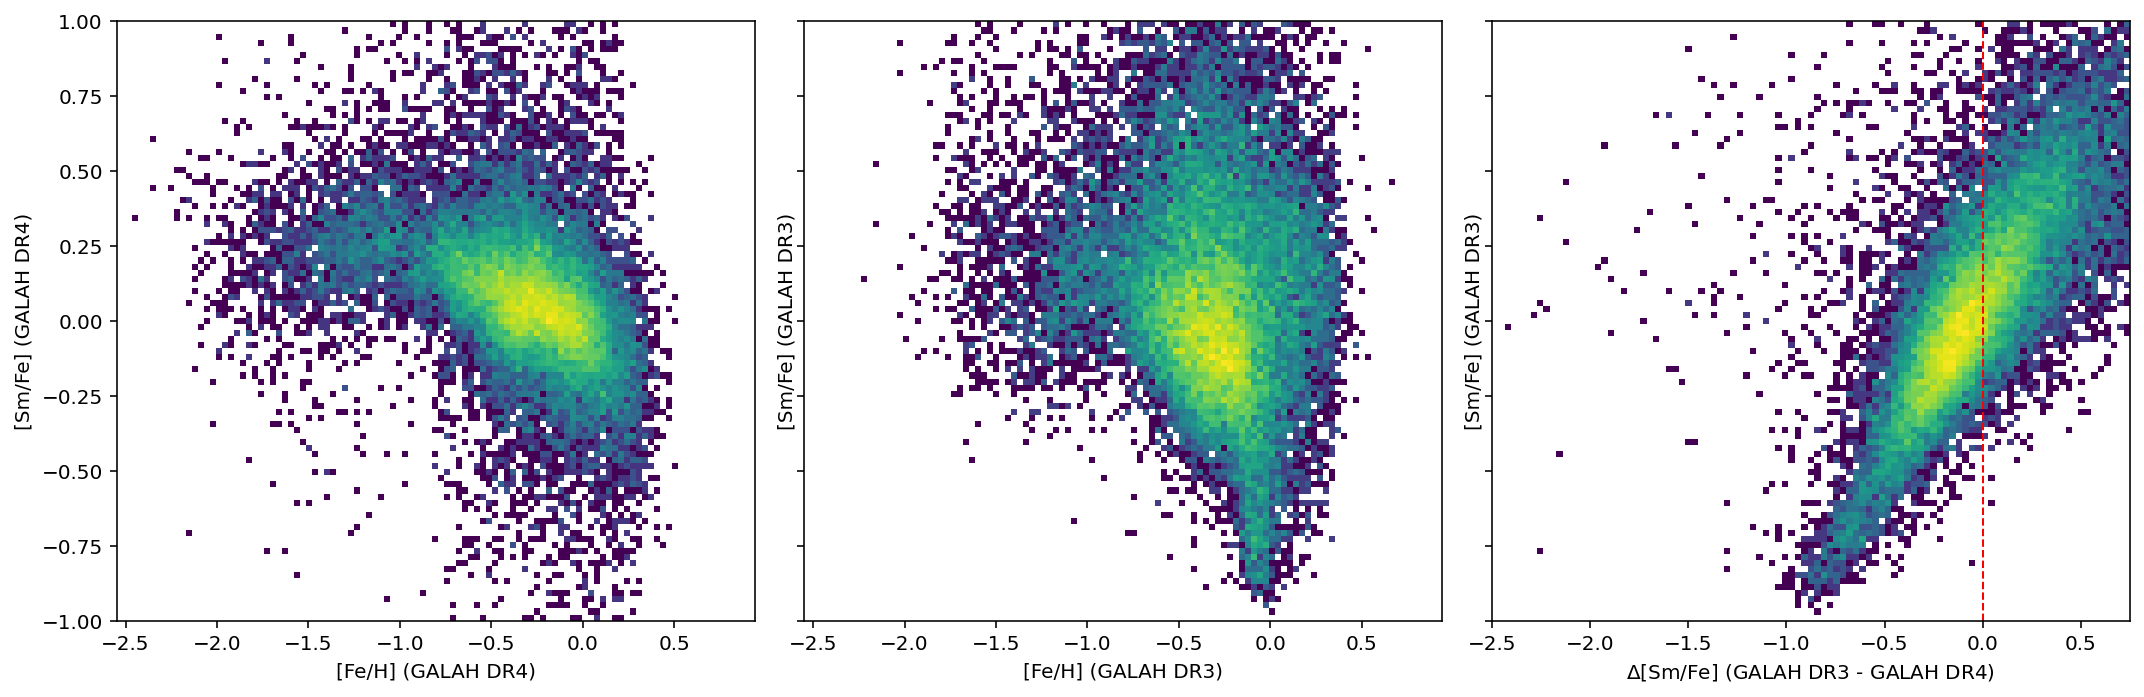

Eu [-0.49587823]


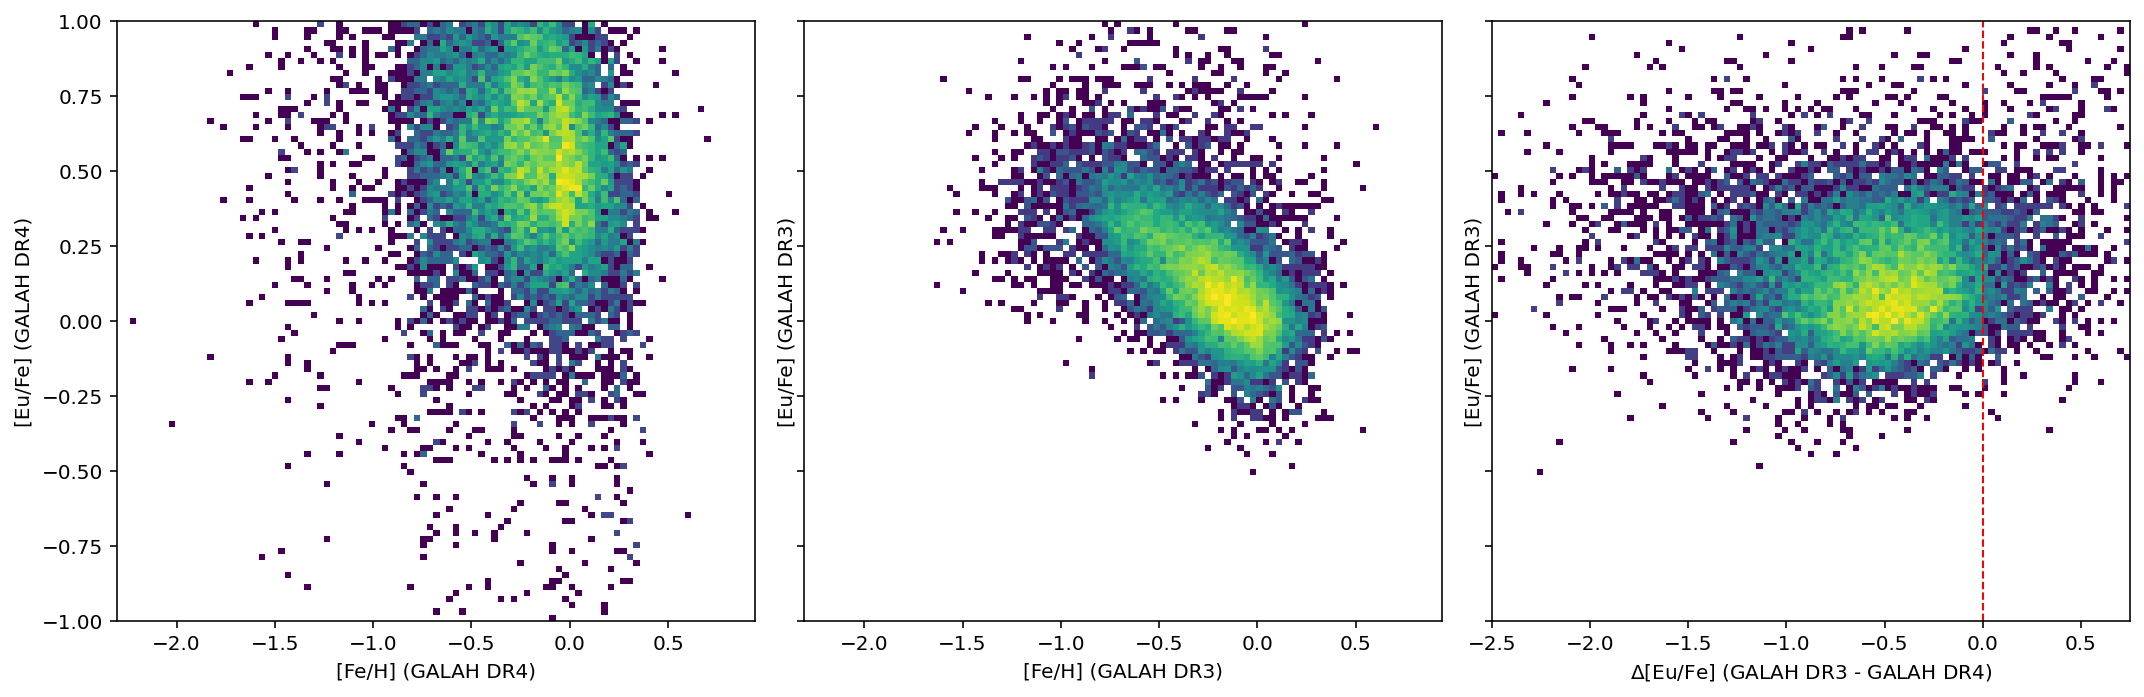

In [14]:
for element in ['Li','C','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu']:
    plot_comparison_xfe(joined, element = element)